# pyheatmy Demo Notebook

This notebook aims to present the various features of `pyheatmy`. It explains how to:
- create a `Column` object from an easy reading of dates
- execute the direct model, for homogeneous (section 2)  and heterogeneous (section 3) riverbeds
- execute the MCMC
- retrieve and display the various results produced during the executions of the direct model or the MCMC

This notebook doesn't provide yet information on the DREAM method implemented in 2023. For that purpose please refer to the `DREAM_VX.ipynb` notebooks

`pyheatmy` is built around the monolithic `Column` class in `core.py`. It can be executed from this class. Calculation, data retrieval, and plotting are methods provided by the `Column` class.

It is based on real data, which can be found in the `data` folder.

We recommend reading the API for more details. 

In [1]:
from pyheatmy import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import namedtuple

## 1. Chargement des données et définition d'un objet ``Column``

On doit d'abord récupérer les données issues des capteurs, qui se trouvent dans le dossier ``data``.

In [2]:
capteur_riviere = pd.read_csv("./data/Point034_processed/processed_pressures.csv", sep = ',', names = ['dates', 'tension', 'temperature_riviere'], skiprows=1)
capteur_ZH = pd.read_csv("./data/Point034_processed/processed_temperatures.csv", sep = ',', names = ['dates', 'temperature_10', 'temperature_20', 'temperature_30', 'temperature_40'], skiprows=1)
etalonage_capteur_riv = pd.read_csv("./configuration/pressure_sensors/P508.csv")

On définit une fonction pour convertir les dates des dataframe, cela peut éviter certains problèmes.

In [3]:
def convertDates(df: pd.DataFrame):
    """
    Convert dates from a list of strings by testing several different input formats
    Try all date formats already encountered in data points
    If none of them is OK, try the generic way (None)
    If the generic way doesn't work, this method fails
    (in that case, you should add the new format to the list)
    
    This function works directly on the giving Pandas dataframe (in place)
    This function assumes that the first column of the given Pandas dataframe
    contains the dates as characters string type
    
    For datetime conversion performance, see:
    See https://stackoverflow.com/questions/40881876/python-pandas-convert-datetime-to-timestamp-effectively-through-dt-accessor
    """
    formats = ("%m/%d/%y %H:%M:%S", "%m/%d/%y %I:%M:%S %p",
               "%d/%m/%y %H:%M",    "%d/%m/%y %I:%M %p",
               "%m/%d/%Y %H:%M:%S", "%m/%d/%Y %I:%M:%S %p", 
               "%d/%m/%Y %H:%M",    "%d/%m/%Y %I:%M %p",
               "%y/%m/%d %H:%M:%S", "%y/%m/%d %I:%M:%S %p", 
               "%y/%m/%d %H:%M",    "%y/%m/%d %I:%M %p",
               "%Y/%m/%d %H:%M:%S", "%Y/%m/%d %I:%M:%S %p", 
               "%Y/%m/%d %H:%M",    "%Y/%m/%d %I:%M %p",
               None)
    times = df[df.columns[0]]
    for f in formats:
        try:
            # Convert strings to datetime objects
            new_times = pd.to_datetime(times, format=f)
            # Convert datetime series to numpy array of integers (timestamps)
            new_ts = new_times.values.astype(np.int64)
            # If times are not ordered, this is not the appropriate format
            test = np.sort(new_ts) - new_ts
            if np.sum(abs(test)) != 0 :
                #print("Order is not the same")
                raise ValueError()
            # Else, the conversion is a success
            #print("Found format ", f)
            df[df.columns[0]] = new_times
            return
        
        except ValueError:
            #print("Format ", f, " not valid")
            continue
    
    # None of the known format are valid
    raise ValueError("Cannot convert dates: No known formats match your data!")

convertDates(capteur_riviere)
convertDates(capteur_ZH)

On définit les objets ``dH_measures`` et ``T_measures``, nécessaires à la création d'un objet ``Column``, qui réalisera les calculs :
- ``dH_measures`` contient les dates des mesures, les mesures de différence de charge, et les températures de la rivière.
- ``T_measures`` contient les dates des mesures, et les températures mesurées par les 4 capteurs de la tige.

In [4]:
# set seed for reproducibility
np.random.seed(0)

# conversion des mesures de pression
intercept = float(etalonage_capteur_riv['P508'][2])
a = float(etalonage_capteur_riv['P508'][3])
b = float(etalonage_capteur_riv['P508'][4])
capteur_riviere['dH'] = (capteur_riviere['tension'].astype(float)-intercept-capteur_riviere['temperature_riviere'].astype(float)*b)/a

# conversion mesures de tempétratures
capteur_riviere['temperature_riviere'] = capteur_riviere['temperature_riviere'] + ZERO_CELSIUS
capteur_ZH['temperature_10'] = capteur_ZH['temperature_10'] + ZERO_CELSIUS
capteur_ZH['temperature_20'] = capteur_ZH['temperature_20'] + ZERO_CELSIUS
capteur_ZH['temperature_30'] = capteur_ZH['temperature_30'] + ZERO_CELSIUS
capteur_ZH['temperature_40'] = capteur_ZH['temperature_40'] + ZERO_CELSIUS

# définition des attributs de colonnes
dH_measures = list(zip(capteur_riviere['dates'],list(zip(capteur_riviere['dH'], capteur_riviere['temperature_riviere']))))
T_measures = list(zip(capteur_ZH['dates'], capteur_ZH[['temperature_10', 'temperature_20', 'temperature_30', 'temperature_40']].to_numpy()))

print(f"dH : {dH_measures}")
print(f"Tshaft : {T_measures}")


dH : [(Timestamp('2016-06-28 06:45:00'), (0.8455651738980304, 287.16499999999996)), (Timestamp('2016-06-28 07:00:00'), (0.845598722046913, 287.159)), (Timestamp('2016-06-28 07:15:00'), (0.84563866885015, 287.15799999999996)), (Timestamp('2016-06-28 07:30:00'), (0.8456745294855709, 287.15599999999995)), (Timestamp('2016-06-28 07:45:00'), (0.8457087531923185, 287.15599999999995)), (Timestamp('2016-06-28 08:00:00'), (0.8457346869561947, 287.15599999999995)), (Timestamp('2016-06-28 08:15:00'), (0.8457538391584245, 287.161)), (Timestamp('2016-06-28 08:30:00'), (0.8457628039753982, 287.167)), (Timestamp('2016-06-28 08:45:00'), (0.8457635267129118, 287.174)), (Timestamp('2016-06-28 09:00:00'), (0.8457572935292086, 287.179)), (Timestamp('2016-06-28 09:15:00'), (0.8457517700915217, 287.185)), (Timestamp('2016-06-28 09:30:00'), (0.8457492408521055, 287.19399999999996)), (Timestamp('2016-06-28 09:45:00'), (0.8457605113179875, 287.21799999999996)), (Timestamp('2016-06-28 10:00:00'), (0.84577645940

On définit maintenant l'objet ``Column`` à partir d'un dictionnaire.

In [5]:
Zbottom = 0.4

col_dict = {
	"river_bed": 1., 
    "depth_sensors": [.1, .2, .3, Zbottom],
	"offset": .0,
    "dH_measures": dH_measures,
	"T_measures": T_measures,
    "sigma_meas_P": None,
    "sigma_meas_T": None,
    "inter_mode": 'lagrange'
}

col = Column.from_dict(col_dict)

L'objet créé a déjà un certain nombre d'attributs, certains étant initialisés. Se reporter au code ``core.py``.

## 2. Colonne homogène

Le modèle direct calcule les températures au cours du temps dans la colonne. Ensuite, on a accès aux flux, à la RMSE...

### 2.1. Modèle direct

Pour une colonne homogène, on définit un seul jeu de paramètres, par un tuple ou via la classe ``Param`` :

In [6]:
moinslog10IntrinK = 11
n = .1
lambda_s = 2
rhos_cs = 4e6
q = 1e-3
heat_depth = 2 # position de la cellule en terme de case, multiplie par 10) 
params = Param(moinslog10IntrinK,n,lambda_s,rhos_cs, q, heat_depth)
# assert params == params_tuple


Puis on appelle le modèle direct :

In [7]:
col.compute_solve_transi(params, verbose=True)

--- Compute Solve Transi ---
One layer : moinslog10IntrinK = 11, n = 0.1, lambda_s = 2, rhos_cs = 4000000.0, q = 0.001, heat_depth = 2
[2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2.]
Solving the flow with intrinsec permeability 1e-11, and permeability 9.810000000000001e-05
Done.


Et on utilise les méthodes de récupération des résultats et de tracer

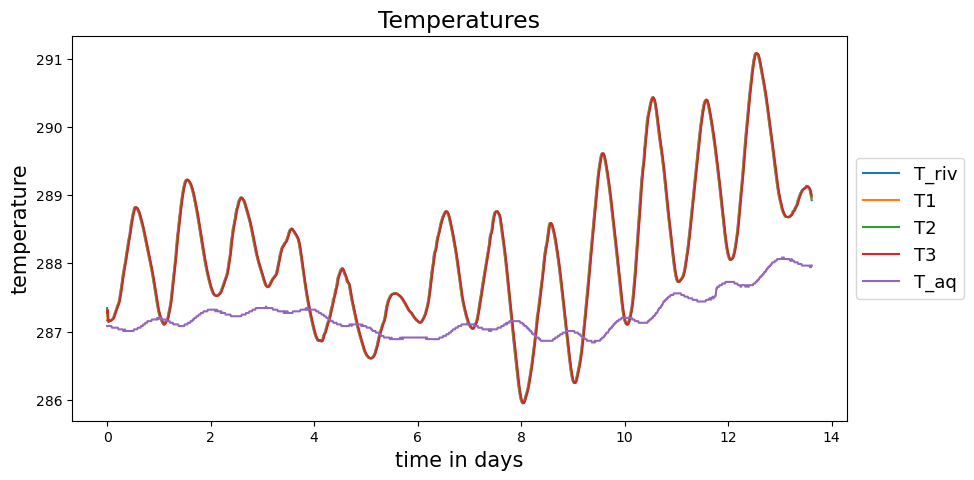

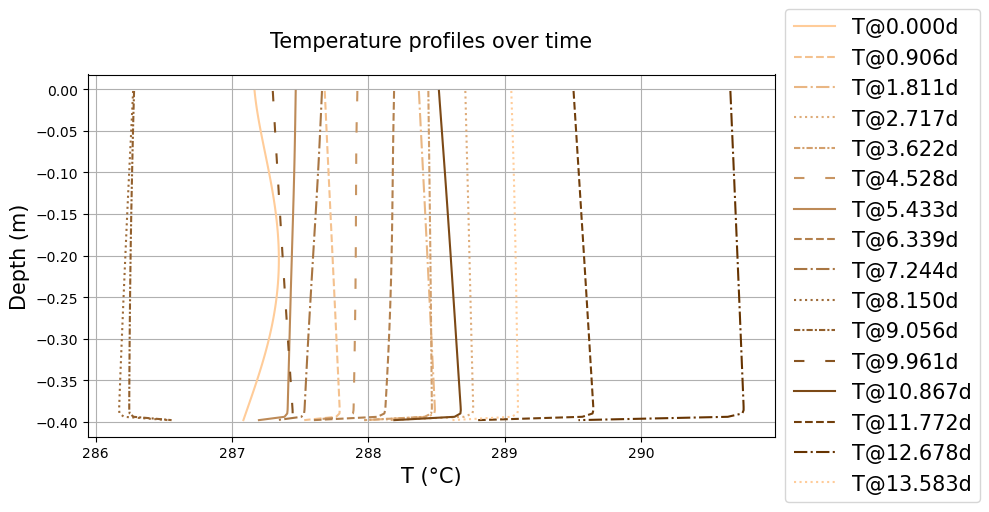

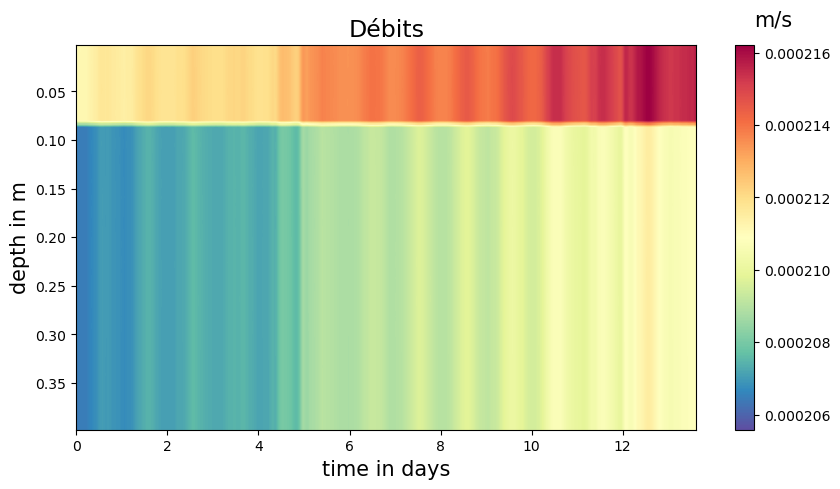

In [8]:
col.plot_temperature_at_sensors()

nt = len(col._temperatures[0,:])
dplot=15
col.plot_temperatures_umbrella(round(nt/dplot))

flows = col.get_flows_solve()
unitLeg="m/s"
title="Débits"
col.plot_it_Zt(flows,title,unitLeg,1.04,2)

Calcul des écarts de température et comparaison des températures simulées et observées

RMSE at sensor 0 : 0.5227364532672474
RMSE at sensor 1 : 0.8846483748357509
RMSE at sensor 2 : 1.0701227384326093
Total RMSE : 0.8565471035859544


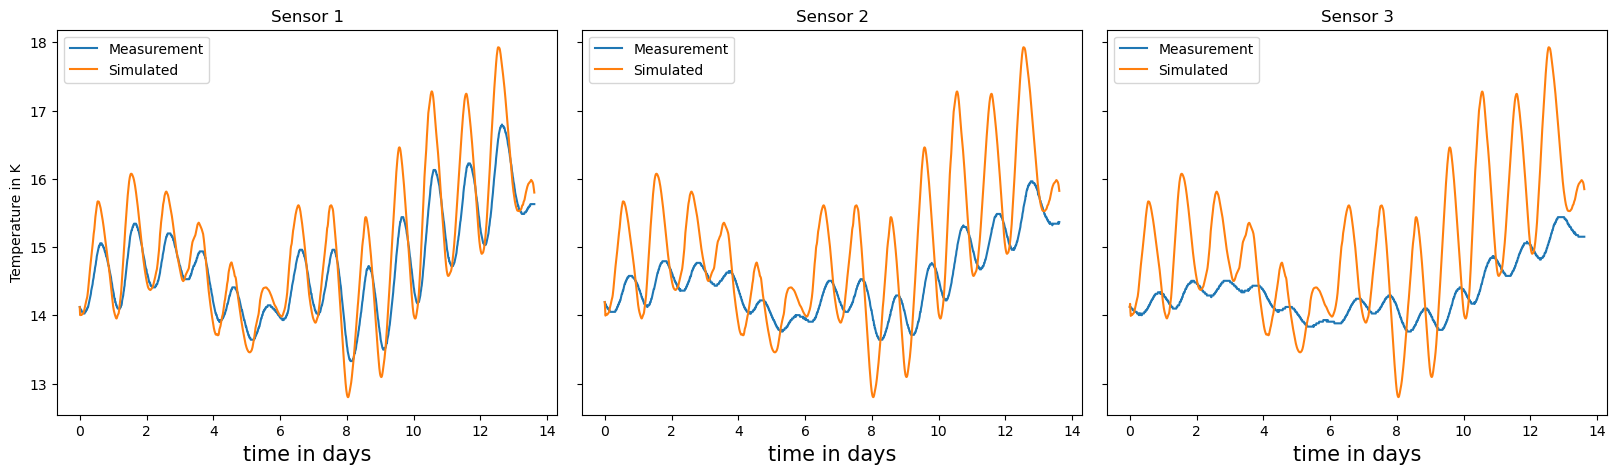

In [9]:
col.print_RMSE_at_sensor()
col.plot_compare_temperatures_sensors()

The simulations are of very pour quality. Let's inverse the data with mcmc

### 2.2 Bayesian inversion

{'moinslog10IntrinK': ((11, 16), 0.01), 'n': ((0.01, 0.25), 0.01), 'lambda_s': ((1, 10), 0.1), 'rhos_cs': ((1000000.0, 10000000.0), 100000.0), 'q': ((1e-09, 1e-05), 1e-07), 'heat_depth': ((0, 10), 1)}
6
6
6
6
6
6
6
6
--- Compute DREAM MCMC ---
Priors :
    [Prior sur une valeure qui évolue entre 11 et 16, Prior sur une valeure qui évolue entre 0.01 et 0.25, Prior sur une valeure qui évolue entre 1 et 10, Prior sur une valeure qui évolue entre 1000000.0 et 10000000.0, Prior sur une valeure qui évolue entre 1e-09 et 1e-05, Prior sur une valeure qui évolue entre 0 et 10]
Number of cells : 100
Number of iterations : 20
Number of chains : 6
--------------------
[9.86213073 9.86213073 9.86213073 9.86213073 9.86213073 9.86213073
 9.86213073 9.86213073 9.86213073 9.86213073 9.86213073 9.86213073
 9.86213073 9.86213073 9.86213073 9.86213073 9.86213073 9.86213073
 9.86213073 9.86213073 9.86213073 9.86213073 9.86213073 9.86213073
 9.86213073 9.86213073 9.86213073 9.86213073 9.86213073 9.86213073


Burn in phase:   0%|          | 0/20 [00:00<?, ?it/s]

[9.6668827 9.6668827 9.6668827 9.6668827 9.6668827 9.6668827 9.6668827
 9.6668827 9.6668827 9.6668827 9.6668827 9.6668827 9.6668827 9.6668827
 9.6668827 9.6668827 9.6668827 9.6668827 9.6668827 9.6668827 9.6668827
 9.6668827 9.6668827 9.6668827 9.6668827 9.6668827 9.6668827 9.6668827
 9.6668827 9.6668827 9.6668827 9.6668827 9.6668827 9.6668827 9.6668827
 9.6668827 9.6668827 9.6668827 9.6668827 9.6668827 9.6668827 9.6668827
 9.6668827 9.6668827 9.6668827 9.6668827 9.6668827 9.6668827 9.6668827
 9.6668827 9.6668827 9.6668827 9.6668827 9.6668827 9.6668827 9.6668827
 9.6668827 9.6668827 9.6668827 9.6668827 9.6668827 9.6668827 9.6668827
 9.6668827 9.6668827 9.6668827 9.6668827 9.6668827 9.6668827 9.6668827
 9.6668827 9.6668827 9.6668827 9.6668827 9.6668827 9.6668827 9.6668827
 9.6668827 9.6668827 9.6668827 9.6668827 9.6668827 9.6668827 9.6668827
 9.6668827 9.6668827 9.6668827 9.6668827 9.6668827 9.6668827 9.6668827
 9.6668827 9.6668827 9.6668827 9.6668827 9.6668827 9.6668827 9.6668827
 9.666

Burn in phase:   5%|▌         | 1/20 [00:02<00:47,  2.47s/it]

[7.31974601 7.31974601 7.31974601 7.31974601 7.31974601 7.31974601
 7.31974601 7.31974601 7.31974601 7.31974601 7.31974601 7.31974601
 7.31974601 7.31974601 7.31974601 7.31974601 7.31974601 7.31974601
 7.31974601 7.31974601 7.31974601 7.31974601 7.31974601 7.31974601
 7.31974601 7.31974601 7.31974601 7.31974601 7.31974601 7.31974601
 7.31974601 7.31974601 7.31974601 7.31974601 7.31974601 7.31974601
 7.31974601 7.31974601 7.31974601 7.31974601 7.31974601 7.31974601
 7.31974601 7.31974601 7.31974601 7.31974601 7.31974601 7.31974601
 7.31974601 7.31974601 7.31974601 7.31974601 7.31974601 7.31974601
 7.31974601 7.31974601 7.31974601 7.31974601 7.31974601 7.31974601
 7.31974601 7.31974601 7.31974601 7.31974601 7.31974601 7.31974601
 7.31974601 7.31974601 7.31974601 7.31974601 7.31974601 7.31974601
 7.31974601 7.31974601 7.31974601 7.31974601 7.31974601 7.31974601
 7.31974601 7.31974601 7.31974601 7.31974601 7.31974601 7.31974601
 7.31974601 7.31974601 7.31974601 7.31974601 7.31974601 7.3197

Burn in phase:  10%|█         | 2/20 [00:05<00:45,  2.54s/it]

[6.44940037 6.44940037 6.44940037 6.44940037 6.44940037 6.44940037
 6.44940037 6.44940037 6.44940037 6.44940037 6.44940037 6.44940037
 6.44940037 6.44940037 6.44940037 6.44940037 6.44940037 6.44940037
 6.44940037 6.44940037 6.44940037 6.44940037 6.44940037 6.44940037
 6.44940037 6.44940037 6.44940037 6.44940037 6.44940037 6.44940037
 6.44940037 6.44940037 6.44940037 6.44940037 6.44940037 6.44940037
 6.44940037 6.44940037 6.44940037 6.44940037 6.44940037 6.44940037
 6.44940037 6.44940037 6.44940037 6.44940037 6.44940037 6.44940037
 6.44940037 6.44940037 6.44940037 6.44940037 6.44940037 6.44940037
 6.44940037 6.44940037 6.44940037 6.44940037 6.44940037 6.44940037
 6.44940037 6.44940037 6.44940037 6.44940037 6.44940037 6.44940037
 6.44940037 6.44940037 6.44940037 6.44940037 6.44940037 6.44940037
 6.44940037 6.44940037 6.44940037 6.44940037 6.44940037 6.44940037
 6.44940037 6.44940037 6.44940037 6.44940037 6.44940037 6.44940037
 6.44940037 6.44940037 6.44940037 6.44940037 6.44940037 6.4494

Burn in phase:  15%|█▌        | 3/20 [00:07<00:41,  2.43s/it]

[4.08685946 4.08685946 4.08685946 4.08685946 4.08685946 4.08685946
 4.08685946 4.08685946 4.08685946 4.08685946 4.08685946 4.08685946
 4.08685946 4.08685946 4.08685946 4.08685946 4.08685946 4.08685946
 4.08685946 4.08685946 4.08685946 4.08685946 4.08685946 4.08685946
 4.08685946 4.08685946 4.08685946 4.08685946 4.08685946 4.08685946
 4.08685946 4.08685946 4.08685946 4.08685946 4.08685946 4.08685946
 4.08685946 4.08685946 4.08685946 4.08685946 4.08685946 4.08685946
 4.08685946 4.08685946 4.08685946 4.08685946 4.08685946 4.08685946
 4.08685946 4.08685946 4.08685946 4.08685946 4.08685946 4.08685946
 4.08685946 4.08685946 4.08685946 4.08685946 4.08685946 4.08685946
 4.08685946 4.08685946 4.08685946 4.08685946 4.08685946 4.08685946
 4.08685946 4.08685946 4.08685946 4.08685946 4.08685946 4.08685946
 4.08685946 4.08685946 4.08685946 4.08685946 4.08685946 4.08685946
 4.08685946 4.08685946 4.08685946 4.08685946 4.08685946 4.08685946
 4.08685946 4.08685946 4.08685946 4.08685946 4.08685946 4.0868

Burn in phase:  20%|██        | 4/20 [00:10<00:42,  2.68s/it]

[3.5940942 3.5940942 3.5940942 3.5940942 3.5940942 3.5940942 3.5940942
 3.5940942 3.5940942 3.5940942 3.5940942 3.5940942 3.5940942 3.5940942
 3.5940942 3.5940942 3.5940942 3.5940942 3.5940942 3.5940942 3.5940942
 3.5940942 3.5940942 3.5940942 3.5940942 3.5940942 3.5940942 3.5940942
 3.5940942 3.5940942 3.5940942 3.5940942 3.5940942 3.5940942 3.5940942
 3.5940942 3.5940942 3.5940942 3.5940942 3.5940942 3.5940942 3.5940942
 3.5940942 3.5940942 3.5940942 3.5940942 3.5940942 3.5940942 3.5940942
 3.5940942 3.5940942 3.5940942 3.5940942 3.5940942 3.5940942 3.5940942
 3.5940942 3.5940942 3.5940942 3.5940942 3.5940942 3.5940942 3.5940942
 3.5940942 3.5940942 3.5940942 3.5940942 3.5940942 3.5940942 3.5940942
 3.5940942 3.5940942 3.5940942 3.5940942 3.5940942 3.5940942 3.5940942
 3.5940942 3.5940942 3.5940942 3.5940942 3.5940942 3.5940942 3.5940942
 3.5940942 3.5940942 3.5940942 3.5940942 3.5940942 3.5940942 3.5940942
 3.5940942 3.5940942 3.5940942 3.5940942 3.5940942 3.5940942 3.5940942
 3.594

Burn in phase:  25%|██▌       | 5/20 [00:13<00:44,  2.95s/it]

[3.33745653 3.33745653 3.33745653 3.33745653 3.33745653 3.33745653
 3.33745653 3.33745653 3.33745653 3.33745653 3.33745653 3.33745653
 3.33745653 3.33745653 3.33745653 3.33745653 3.33745653 3.33745653
 3.33745653 3.33745653 3.33745653 3.33745653 3.33745653 3.33745653
 3.33745653 3.33745653 3.33745653 3.33745653 3.33745653 3.33745653
 3.33745653 3.33745653 3.33745653 3.33745653 3.33745653 3.33745653
 3.33745653 3.33745653 3.33745653 3.33745653 3.33745653 3.33745653
 3.33745653 3.33745653 3.33745653 3.33745653 3.33745653 3.33745653
 3.33745653 3.33745653 3.33745653 3.33745653 3.33745653 3.33745653
 3.33745653 3.33745653 3.33745653 3.33745653 3.33745653 3.33745653
 3.33745653 3.33745653 3.33745653 3.33745653 3.33745653 3.33745653
 3.33745653 3.33745653 3.33745653 3.33745653 3.33745653 3.33745653
 3.33745653 3.33745653 3.33745653 3.33745653 3.33745653 3.33745653
 3.33745653 3.33745653 3.33745653 3.33745653 3.33745653 3.33745653
 3.33745653 3.33745653 3.33745653 3.33745653 3.33745653 3.3374

Burn in phase:  30%|███       | 6/20 [00:17<00:42,  3.06s/it]

[9.2533671 9.2533671 9.2533671 9.2533671 9.2533671 9.2533671 9.2533671
 9.2533671 9.2533671 9.2533671 9.2533671 9.2533671 9.2533671 9.2533671
 9.2533671 9.2533671 9.2533671 9.2533671 9.2533671 9.2533671 9.2533671
 9.2533671 9.2533671 9.2533671 9.2533671 9.2533671 9.2533671 9.2533671
 9.2533671 9.2533671 9.2533671 9.2533671 9.2533671 9.2533671 9.2533671
 9.2533671 9.2533671 9.2533671 9.2533671 9.2533671 9.2533671 9.2533671
 9.2533671 9.2533671 9.2533671 9.2533671 9.2533671 9.2533671 9.2533671
 9.2533671 9.2533671 9.2533671 9.2533671 9.2533671 9.2533671 9.2533671
 9.2533671 9.2533671 9.2533671 9.2533671 9.2533671 9.2533671 9.2533671
 9.2533671 9.2533671 9.2533671 9.2533671 9.2533671 9.2533671 9.2533671
 9.2533671 9.2533671 9.2533671 9.2533671 9.2533671 9.2533671 9.2533671
 9.2533671 9.2533671 9.2533671 9.2533671 9.2533671 9.2533671 9.2533671
 9.2533671 9.2533671 9.2533671 9.2533671 9.2533671 9.2533671 9.2533671
 9.2533671 9.2533671 9.2533671 9.2533671 9.2533671 9.2533671 9.2533671
 9.253

Burn in phase:  35%|███▌      | 7/20 [00:20<00:40,  3.14s/it]

[0.28555598 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598
 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598
 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598
 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598
 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598
 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598
 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598
 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598
 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598
 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598
 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598
 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598
 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598
 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598
 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598 0.2855

Burn in phase:  40%|████      | 8/20 [00:23<00:38,  3.23s/it]

[0.28555598 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598
 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598
 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598
 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598
 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598
 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598
 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598
 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598
 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598
 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598
 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598
 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598
 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598
 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598
 0.28555598 0.28555598 0.28555598 0.28555598 0.28555598 0.2855

Burn in phase:  45%|████▌     | 9/20 [00:26<00:33,  3.05s/it]

[8.34685127 8.34685127 8.34685127 8.34685127 8.34685127 8.34685127
 8.34685127 8.34685127 8.34685127 8.34685127 8.34685127 8.34685127
 8.34685127 8.34685127 8.34685127 8.34685127 8.34685127 8.34685127
 8.34685127 8.34685127 8.34685127 8.34685127 8.34685127 8.34685127
 8.34685127 8.34685127 8.34685127 8.34685127 8.34685127 8.34685127
 8.34685127 8.34685127 8.34685127 8.34685127 8.34685127 8.34685127
 8.34685127 8.34685127 8.34685127 8.34685127 8.34685127 8.34685127
 8.34685127 8.34685127 8.34685127 8.34685127 8.34685127 8.34685127
 8.34685127 8.34685127 8.34685127 8.34685127 8.34685127 8.34685127
 8.34685127 8.34685127 8.34685127 8.34685127 8.34685127 8.34685127
 8.34685127 8.34685127 8.34685127 8.34685127 8.34685127 8.34685127
 8.34685127 8.34685127 8.34685127 8.34685127 8.34685127 8.34685127
 8.34685127 8.34685127 8.34685127 8.34685127 8.34685127 8.34685127
 8.34685127 8.34685127 8.34685127 8.34685127 8.34685127 8.34685127
 8.34685127 8.34685127 8.34685127 8.34685127 8.34685127 8.3468

Burn in phase:  50%|█████     | 10/20 [00:29<00:30,  3.10s/it]

[3.48551484 3.48551484 3.48551484 3.48551484 3.48551484 3.48551484
 3.48551484 3.48551484 3.48551484 3.48551484 3.48551484 3.48551484
 3.48551484 3.48551484 3.48551484 3.48551484 3.48551484 3.48551484
 3.48551484 3.48551484 3.48551484 3.48551484 3.48551484 3.48551484
 3.48551484 3.48551484 3.48551484 3.48551484 3.48551484 3.48551484
 3.48551484 3.48551484 3.48551484 3.48551484 3.48551484 3.48551484
 3.48551484 3.48551484 3.48551484 3.48551484 3.48551484 3.48551484
 3.48551484 3.48551484 3.48551484 3.48551484 3.48551484 3.48551484
 3.48551484 3.48551484 3.48551484 3.48551484 3.48551484 3.48551484
 3.48551484 3.48551484 3.48551484 3.48551484 3.48551484 3.48551484
 3.48551484 3.48551484 3.48551484 3.48551484 3.48551484 3.48551484
 3.48551484 3.48551484 3.48551484 3.48551484 3.48551484 3.48551484
 3.48551484 3.48551484 3.48551484 3.48551484 3.48551484 3.48551484
 3.48551484 3.48551484 3.48551484 3.48551484 3.48551484 3.48551484
 3.48551484 3.48551484 3.48551484 3.48551484 3.48551484 3.4855

Burn in phase:  55%|█████▌    | 11/20 [00:32<00:25,  2.85s/it]

[2.83897142 2.83897142 2.83897142 2.83897142 2.83897142 2.83897142
 2.83897142 2.83897142 2.83897142 2.83897142 2.83897142 2.83897142
 2.83897142 2.83897142 2.83897142 2.83897142 2.83897142 2.83897142
 2.83897142 2.83897142 2.83897142 2.83897142 2.83897142 2.83897142
 2.83897142 2.83897142 2.83897142 2.83897142 2.83897142 2.83897142
 2.83897142 2.83897142 2.83897142 2.83897142 2.83897142 2.83897142
 2.83897142 2.83897142 2.83897142 2.83897142 2.83897142 2.83897142
 2.83897142 2.83897142 2.83897142 2.83897142 2.83897142 2.83897142
 2.83897142 2.83897142 2.83897142 2.83897142 2.83897142 2.83897142
 2.83897142 2.83897142 2.83897142 2.83897142 2.83897142 2.83897142
 2.83897142 2.83897142 2.83897142 2.83897142 2.83897142 2.83897142
 2.83897142 2.83897142 2.83897142 2.83897142 2.83897142 2.83897142
 2.83897142 2.83897142 2.83897142 2.83897142 2.83897142 2.83897142
 2.83897142 2.83897142 2.83897142 2.83897142 2.83897142 2.83897142
 2.83897142 2.83897142 2.83897142 2.83897142 2.83897142 2.8389

Burn in phase:  60%|██████    | 12/20 [00:35<00:23,  2.98s/it]

[9.70887967 9.70887967 9.70887967 9.70887967 9.70887967 9.70887967
 9.70887967 9.70887967 9.70887967 9.70887967 9.70887967 9.70887967
 9.70887967 9.70887967 9.70887967 9.70887967 9.70887967 9.70887967
 9.70887967 9.70887967 9.70887967 9.70887967 9.70887967 9.70887967
 9.70887967 9.70887967 9.70887967 9.70887967 9.70887967 9.70887967
 9.70887967 9.70887967 9.70887967 9.70887967 9.70887967 9.70887967
 9.70887967 9.70887967 9.70887967 9.70887967 9.70887967 9.70887967
 9.70887967 9.70887967 9.70887967 9.70887967 9.70887967 9.70887967
 9.70887967 9.70887967 9.70887967 9.70887967 9.70887967 9.70887967
 9.70887967 9.70887967 9.70887967 9.70887967 9.70887967 9.70887967
 9.70887967 9.70887967 9.70887967 9.70887967 9.70887967 9.70887967
 9.70887967 9.70887967 9.70887967 9.70887967 9.70887967 9.70887967
 9.70887967 9.70887967 9.70887967 9.70887967 9.70887967 9.70887967
 9.70887967 9.70887967 9.70887967 9.70887967 9.70887967 9.70887967
 9.70887967 9.70887967 9.70887967 9.70887967 9.70887967 9.7088

Burn in phase:  65%|██████▌   | 13/20 [00:38<00:21,  3.09s/it]

[7.79334339 7.79334339 7.79334339 7.79334339 7.79334339 7.79334339
 7.79334339 7.79334339 7.79334339 7.79334339 7.79334339 7.79334339
 7.79334339 7.79334339 7.79334339 7.79334339 7.79334339 7.79334339
 7.79334339 7.79334339 7.79334339 7.79334339 7.79334339 7.79334339
 7.79334339 7.79334339 7.79334339 7.79334339 7.79334339 7.79334339
 7.79334339 7.79334339 7.79334339 7.79334339 7.79334339 7.79334339
 7.79334339 7.79334339 7.79334339 7.79334339 7.79334339 7.79334339
 7.79334339 7.79334339 7.79334339 7.79334339 7.79334339 7.79334339
 7.79334339 7.79334339 7.79334339 7.79334339 7.79334339 7.79334339
 7.79334339 7.79334339 7.79334339 7.79334339 7.79334339 7.79334339
 7.79334339 7.79334339 7.79334339 7.79334339 7.79334339 7.79334339
 7.79334339 7.79334339 7.79334339 7.79334339 7.79334339 7.79334339
 7.79334339 7.79334339 7.79334339 7.79334339 7.79334339 7.79334339
 7.79334339 7.79334339 7.79334339 7.79334339 7.79334339 7.79334339
 7.79334339 7.79334339 7.79334339 7.79334339 7.79334339 7.7933

Burn in phase:  70%|███████   | 14/20 [00:41<00:18,  3.12s/it]

[6.7244292 6.7244292 6.7244292 6.7244292 6.7244292 6.7244292 6.7244292
 6.7244292 6.7244292 6.7244292 6.7244292 6.7244292 6.7244292 6.7244292
 6.7244292 6.7244292 6.7244292 6.7244292 6.7244292 6.7244292 6.7244292
 6.7244292 6.7244292 6.7244292 6.7244292 6.7244292 6.7244292 6.7244292
 6.7244292 6.7244292 6.7244292 6.7244292 6.7244292 6.7244292 6.7244292
 6.7244292 6.7244292 6.7244292 6.7244292 6.7244292 6.7244292 6.7244292
 6.7244292 6.7244292 6.7244292 6.7244292 6.7244292 6.7244292 6.7244292
 6.7244292 6.7244292 6.7244292 6.7244292 6.7244292 6.7244292 6.7244292
 6.7244292 6.7244292 6.7244292 6.7244292 6.7244292 6.7244292 6.7244292
 6.7244292 6.7244292 6.7244292 6.7244292 6.7244292 6.7244292 6.7244292
 6.7244292 6.7244292 6.7244292 6.7244292 6.7244292 6.7244292 6.7244292
 6.7244292 6.7244292 6.7244292 6.7244292 6.7244292 6.7244292 6.7244292
 6.7244292 6.7244292 6.7244292 6.7244292 6.7244292 6.7244292 6.7244292
 6.7244292 6.7244292 6.7244292 6.7244292 6.7244292 6.7244292 6.7244292
 6.724

Burn in phase:  75%|███████▌  | 15/20 [00:45<00:16,  3.22s/it]

[5.07734661 5.07734661 5.07734661 5.07734661 5.07734661 5.07734661
 5.07734661 5.07734661 5.07734661 5.07734661 5.07734661 5.07734661
 5.07734661 5.07734661 5.07734661 5.07734661 5.07734661 5.07734661
 5.07734661 5.07734661 5.07734661 5.07734661 5.07734661 5.07734661
 5.07734661 5.07734661 5.07734661 5.07734661 5.07734661 5.07734661
 5.07734661 5.07734661 5.07734661 5.07734661 5.07734661 5.07734661
 5.07734661 5.07734661 5.07734661 5.07734661 5.07734661 5.07734661
 5.07734661 5.07734661 5.07734661 5.07734661 5.07734661 5.07734661
 5.07734661 5.07734661 5.07734661 5.07734661 5.07734661 5.07734661
 5.07734661 5.07734661 5.07734661 5.07734661 5.07734661 5.07734661
 5.07734661 5.07734661 5.07734661 5.07734661 5.07734661 5.07734661
 5.07734661 5.07734661 5.07734661 5.07734661 5.07734661 5.07734661
 5.07734661 5.07734661 5.07734661 5.07734661 5.07734661 5.07734661
 5.07734661 5.07734661 5.07734661 5.07734661 5.07734661 5.07734661
 5.07734661 5.07734661 5.07734661 5.07734661 5.07734661 5.0773

Burn in phase:  80%|████████  | 16/20 [00:48<00:12,  3.22s/it]

[2.88090539 2.88090539 2.88090539 2.88090539 2.88090539 2.88090539
 2.88090539 2.88090539 2.88090539 2.88090539 2.88090539 2.88090539
 2.88090539 2.88090539 2.88090539 2.88090539 2.88090539 2.88090539
 2.88090539 2.88090539 2.88090539 2.88090539 2.88090539 2.88090539
 2.88090539 2.88090539 2.88090539 2.88090539 2.88090539 2.88090539
 2.88090539 2.88090539 2.88090539 2.88090539 2.88090539 2.88090539
 2.88090539 2.88090539 2.88090539 2.88090539 2.88090539 2.88090539
 2.88090539 2.88090539 2.88090539 2.88090539 2.88090539 2.88090539
 2.88090539 2.88090539 2.88090539 2.88090539 2.88090539 2.88090539
 2.88090539 2.88090539 2.88090539 2.88090539 2.88090539 2.88090539
 2.88090539 2.88090539 2.88090539 2.88090539 2.88090539 2.88090539
 2.88090539 2.88090539 2.88090539 2.88090539 2.88090539 2.88090539
 2.88090539 2.88090539 2.88090539 2.88090539 2.88090539 2.88090539
 2.88090539 2.88090539 2.88090539 2.88090539 2.88090539 2.88090539
 2.88090539 2.88090539 2.88090539 2.88090539 2.88090539 2.8809

Burn in phase:  85%|████████▌ | 17/20 [00:50<00:08,  2.94s/it]

[0.36800552 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552
 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552
 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552
 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552
 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552
 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552
 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552
 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552
 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552
 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552
 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552
 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552
 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552
 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552
 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552 0.3680

Burn in phase:  90%|█████████ | 18/20 [00:54<00:06,  3.09s/it]

[0.36800552 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552
 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552
 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552
 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552
 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552
 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552
 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552
 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552
 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552
 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552
 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552
 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552
 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552
 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552
 0.36800552 0.36800552 0.36800552 0.36800552 0.36800552 0.3680

Burn in phase:  95%|█████████▌| 19/20 [00:57<00:03,  3.13s/it]

[1.63643396 1.63643396 1.63643396 1.63643396 1.63643396 1.63643396
 1.63643396 1.63643396 1.63643396 1.63643396 1.63643396 1.63643396
 1.63643396 1.63643396 1.63643396 1.63643396 1.63643396 1.63643396
 1.63643396 1.63643396 1.63643396 1.63643396 1.63643396 1.63643396
 1.63643396 1.63643396 1.63643396 1.63643396 1.63643396 1.63643396
 1.63643396 1.63643396 1.63643396 1.63643396 1.63643396 1.63643396
 1.63643396 1.63643396 1.63643396 1.63643396 1.63643396 1.63643396
 1.63643396 1.63643396 1.63643396 1.63643396 1.63643396 1.63643396
 1.63643396 1.63643396 1.63643396 1.63643396 1.63643396 1.63643396
 1.63643396 1.63643396 1.63643396 1.63643396 1.63643396 1.63643396
 1.63643396 1.63643396 1.63643396 1.63643396 1.63643396 1.63643396
 1.63643396 1.63643396 1.63643396 1.63643396 1.63643396 1.63643396
 1.63643396 1.63643396 1.63643396 1.63643396 1.63643396 1.63643396
 1.63643396 1.63643396 1.63643396 1.63643396 1.63643396 1.63643396
 1.63643396 1.63643396 1.63643396 1.63643396 1.63643396 1.6364

Burn in phase: 100%|██████████| 20/20 [01:00<00:00,  3.04s/it]


Initialisation post burn-in - Utilisation de la mémoire (en Mo) : 277.1968
DREAM MCMC Computation:   0%|          | 0/20 [00:00<?, ?it/s][3.3528376 3.3528376 3.3528376 3.3528376 3.3528376 3.3528376 3.3528376
 3.3528376 3.3528376 3.3528376 3.3528376 3.3528376 3.3528376 3.3528376
 3.3528376 3.3528376 3.3528376 3.3528376 3.3528376 3.3528376 3.3528376
 3.3528376 3.3528376 3.3528376 3.3528376 3.3528376 3.3528376 3.3528376
 3.3528376 3.3528376 3.3528376 3.3528376 3.3528376 3.3528376 3.3528376
 3.3528376 3.3528376 3.3528376 3.3528376 3.3528376 3.3528376 3.3528376
 3.3528376 3.3528376 3.3528376 3.3528376 3.3528376 3.3528376 3.3528376
 3.3528376 3.3528376 3.3528376 3.3528376 3.3528376 3.3528376 3.3528376
 3.3528376 3.3528376 3.3528376 3.3528376 3.3528376 3.3528376 3.3528376
 3.3528376 3.3528376 3.3528376 3.3528376 3.3528376 3.3528376 3.3528376
 3.3528376 3.3528376 3.3528376 3.3528376 3.3528376 3.3528376 3.3528376
 3.3528376 3.3528376 3.3528376 3.3528376 3.3528376 3.3528376 3.3528376
 3.3528376 

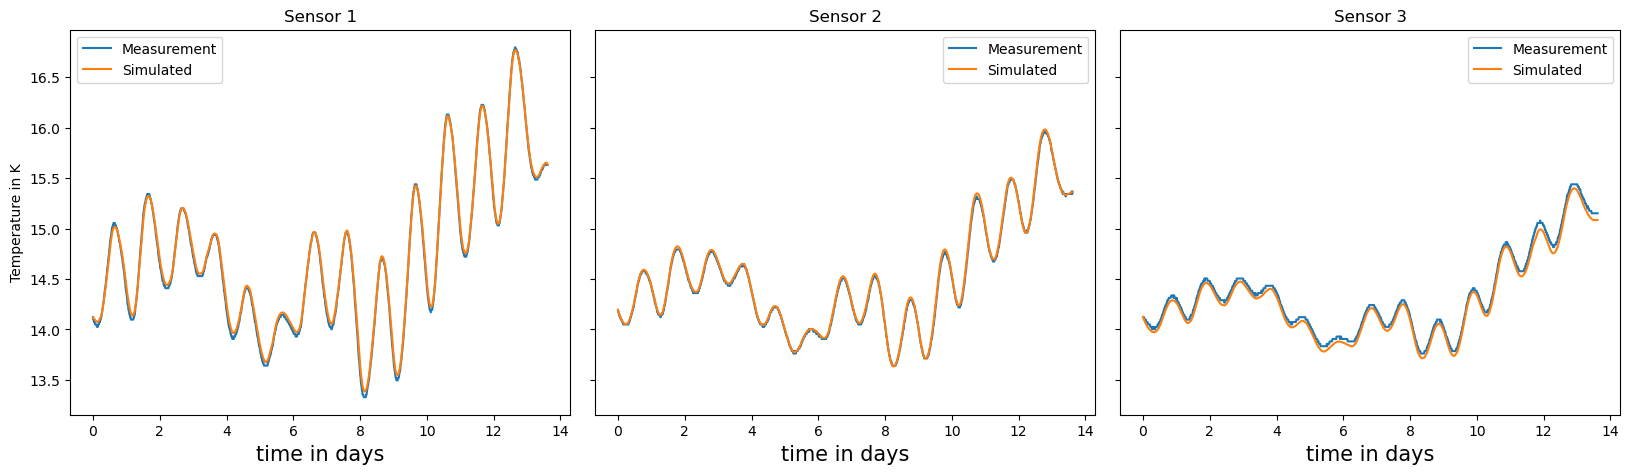

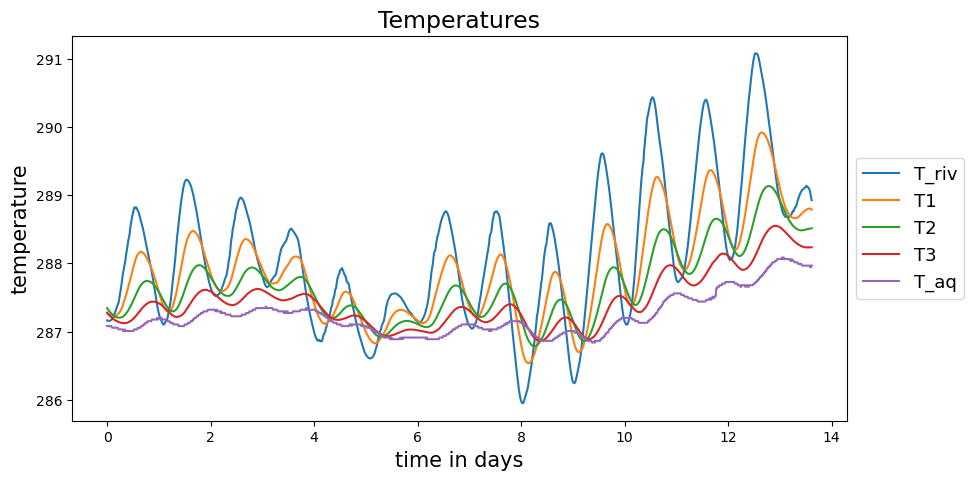

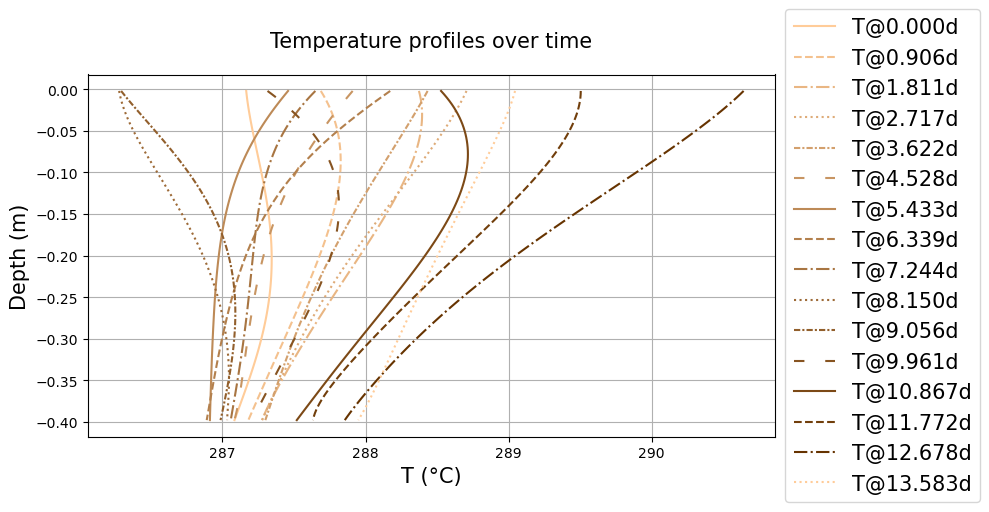

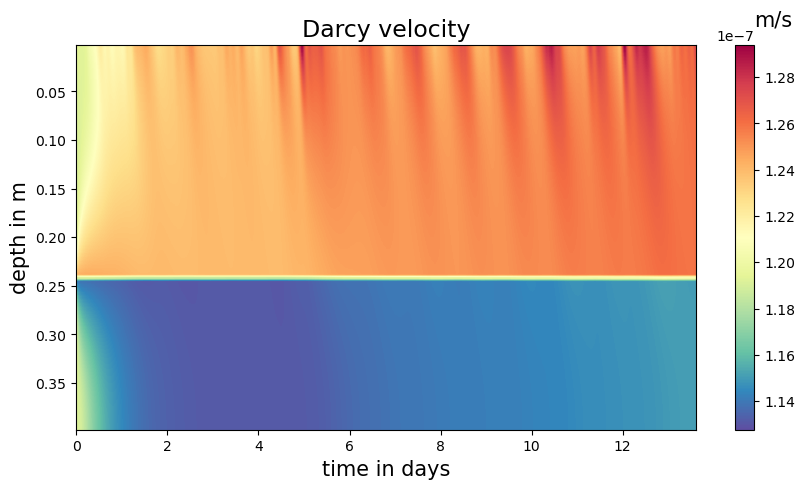

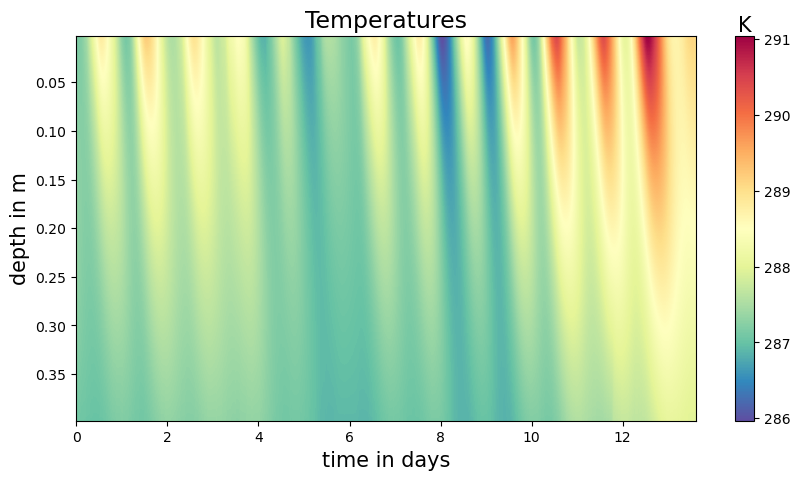

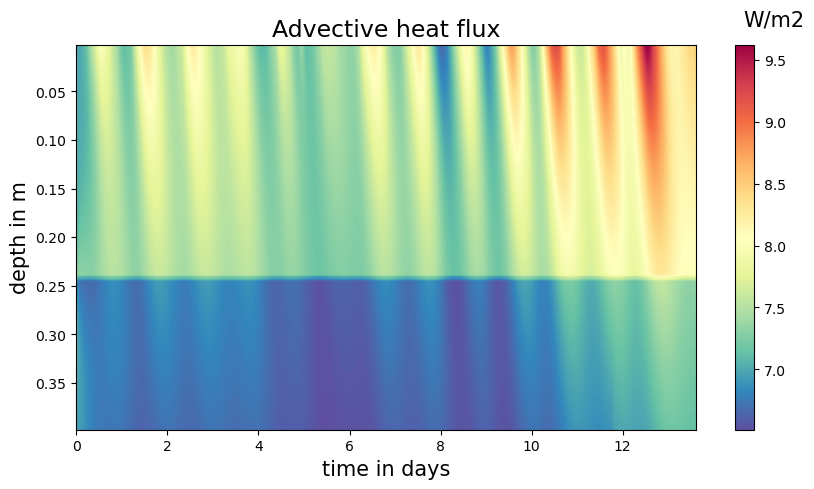

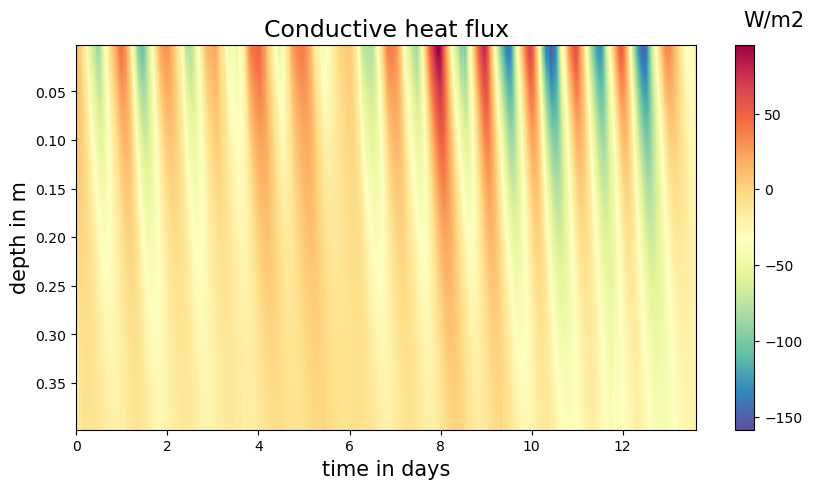

Plotting Température in column. time series have nrecords =  1309


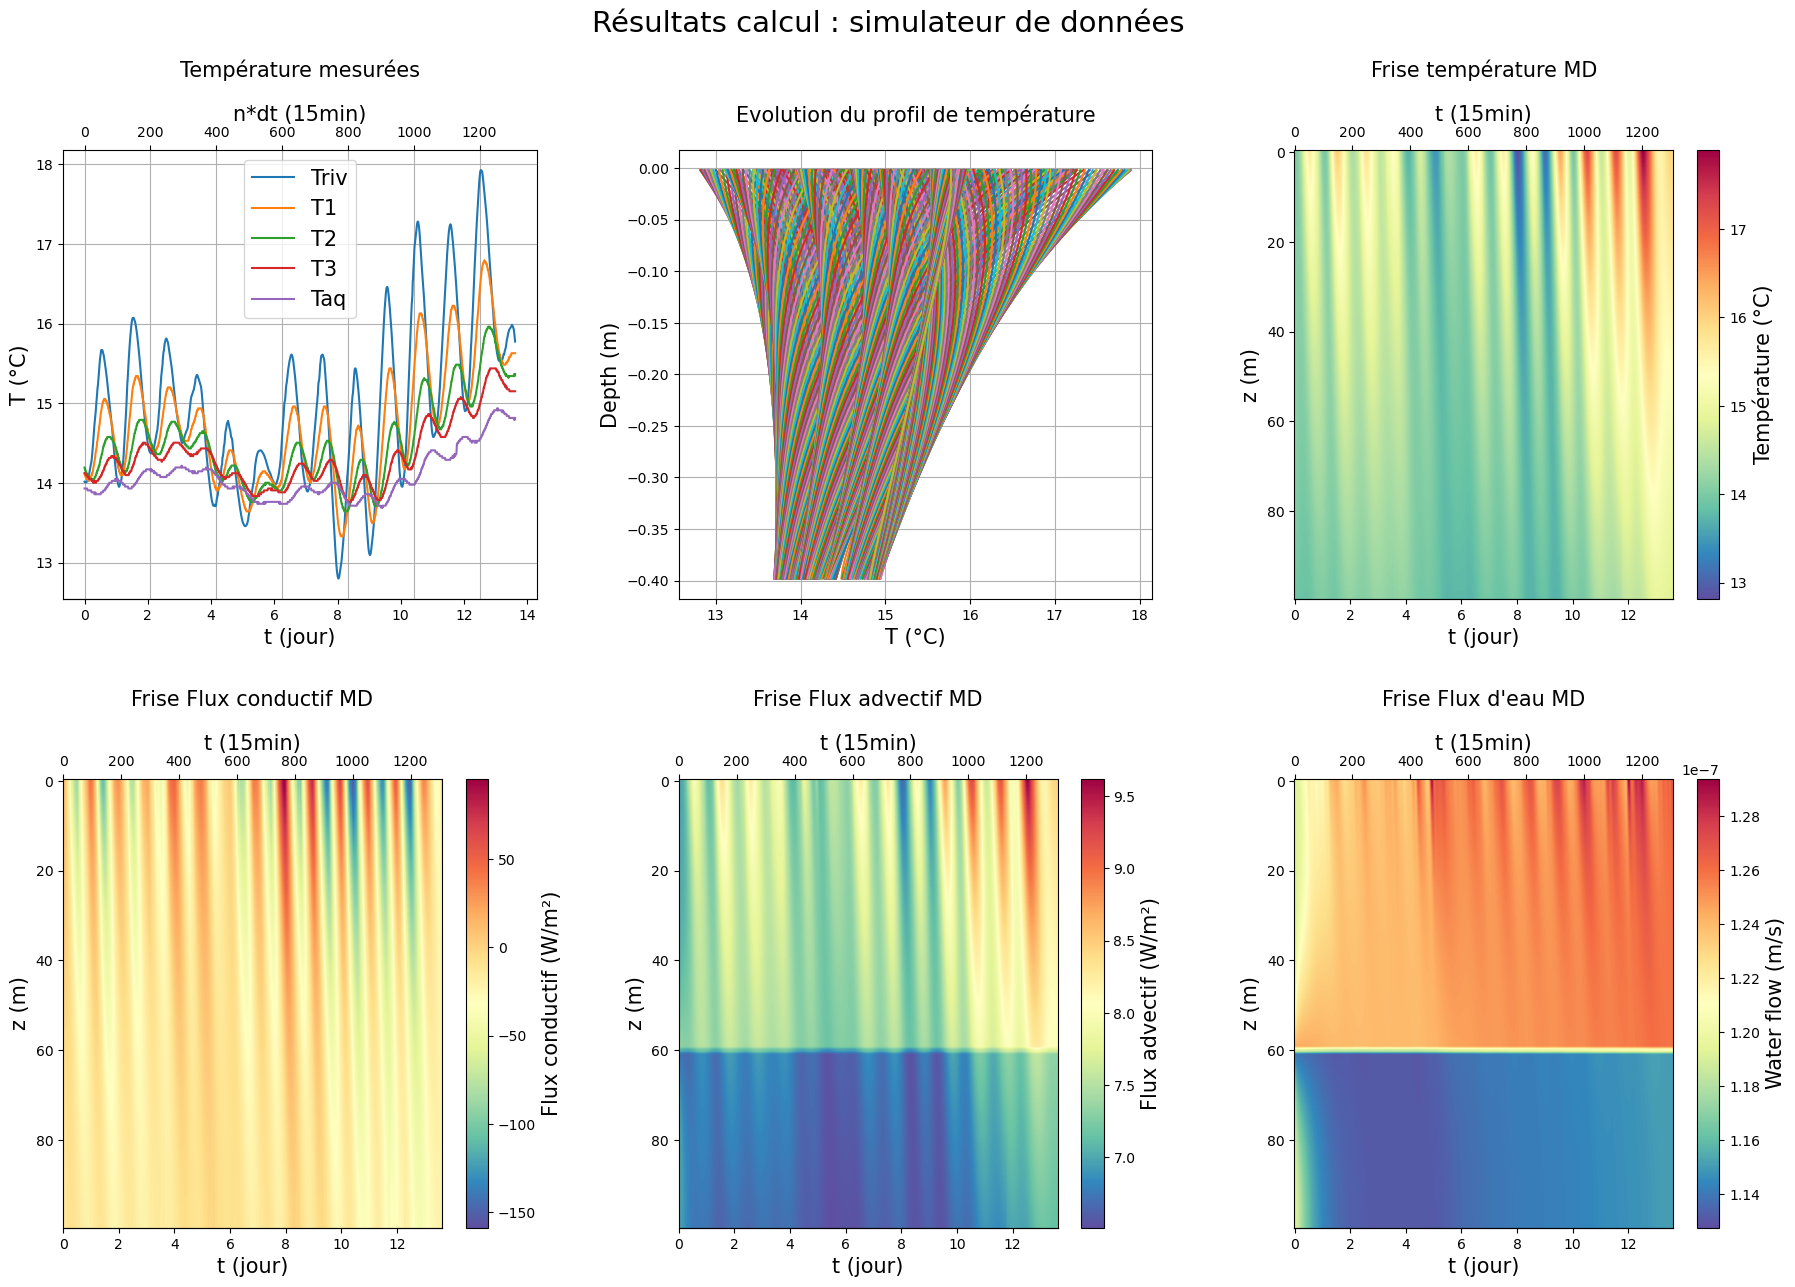

In [10]:
priors = {
    "moinslog10IntrinK": ((4+7, 9+7), .01), # (intervalle, sigma)
    "n": ((.01, .25), .01),
    "lambda_s": ((1, 10), .1),
    "rhos_cs": ((1e6,1e7), 1e5),
    "q": ((1e-9, 1e-5), 1e-7),
    "heat_depth": ((0, 10), 1),
}

all_priors = [
    ['Couche 1', Zbottom, priors],
]
col.compute_mcmc(
    nb_iter = 20,
    all_priors = all_priors,
    sigma2=1.0,
    verbose=True
)

bestLayers = col.get_best_layers()
col.compute_solve_transi(bestLayers, verbose=False)
col.plot_all_results()

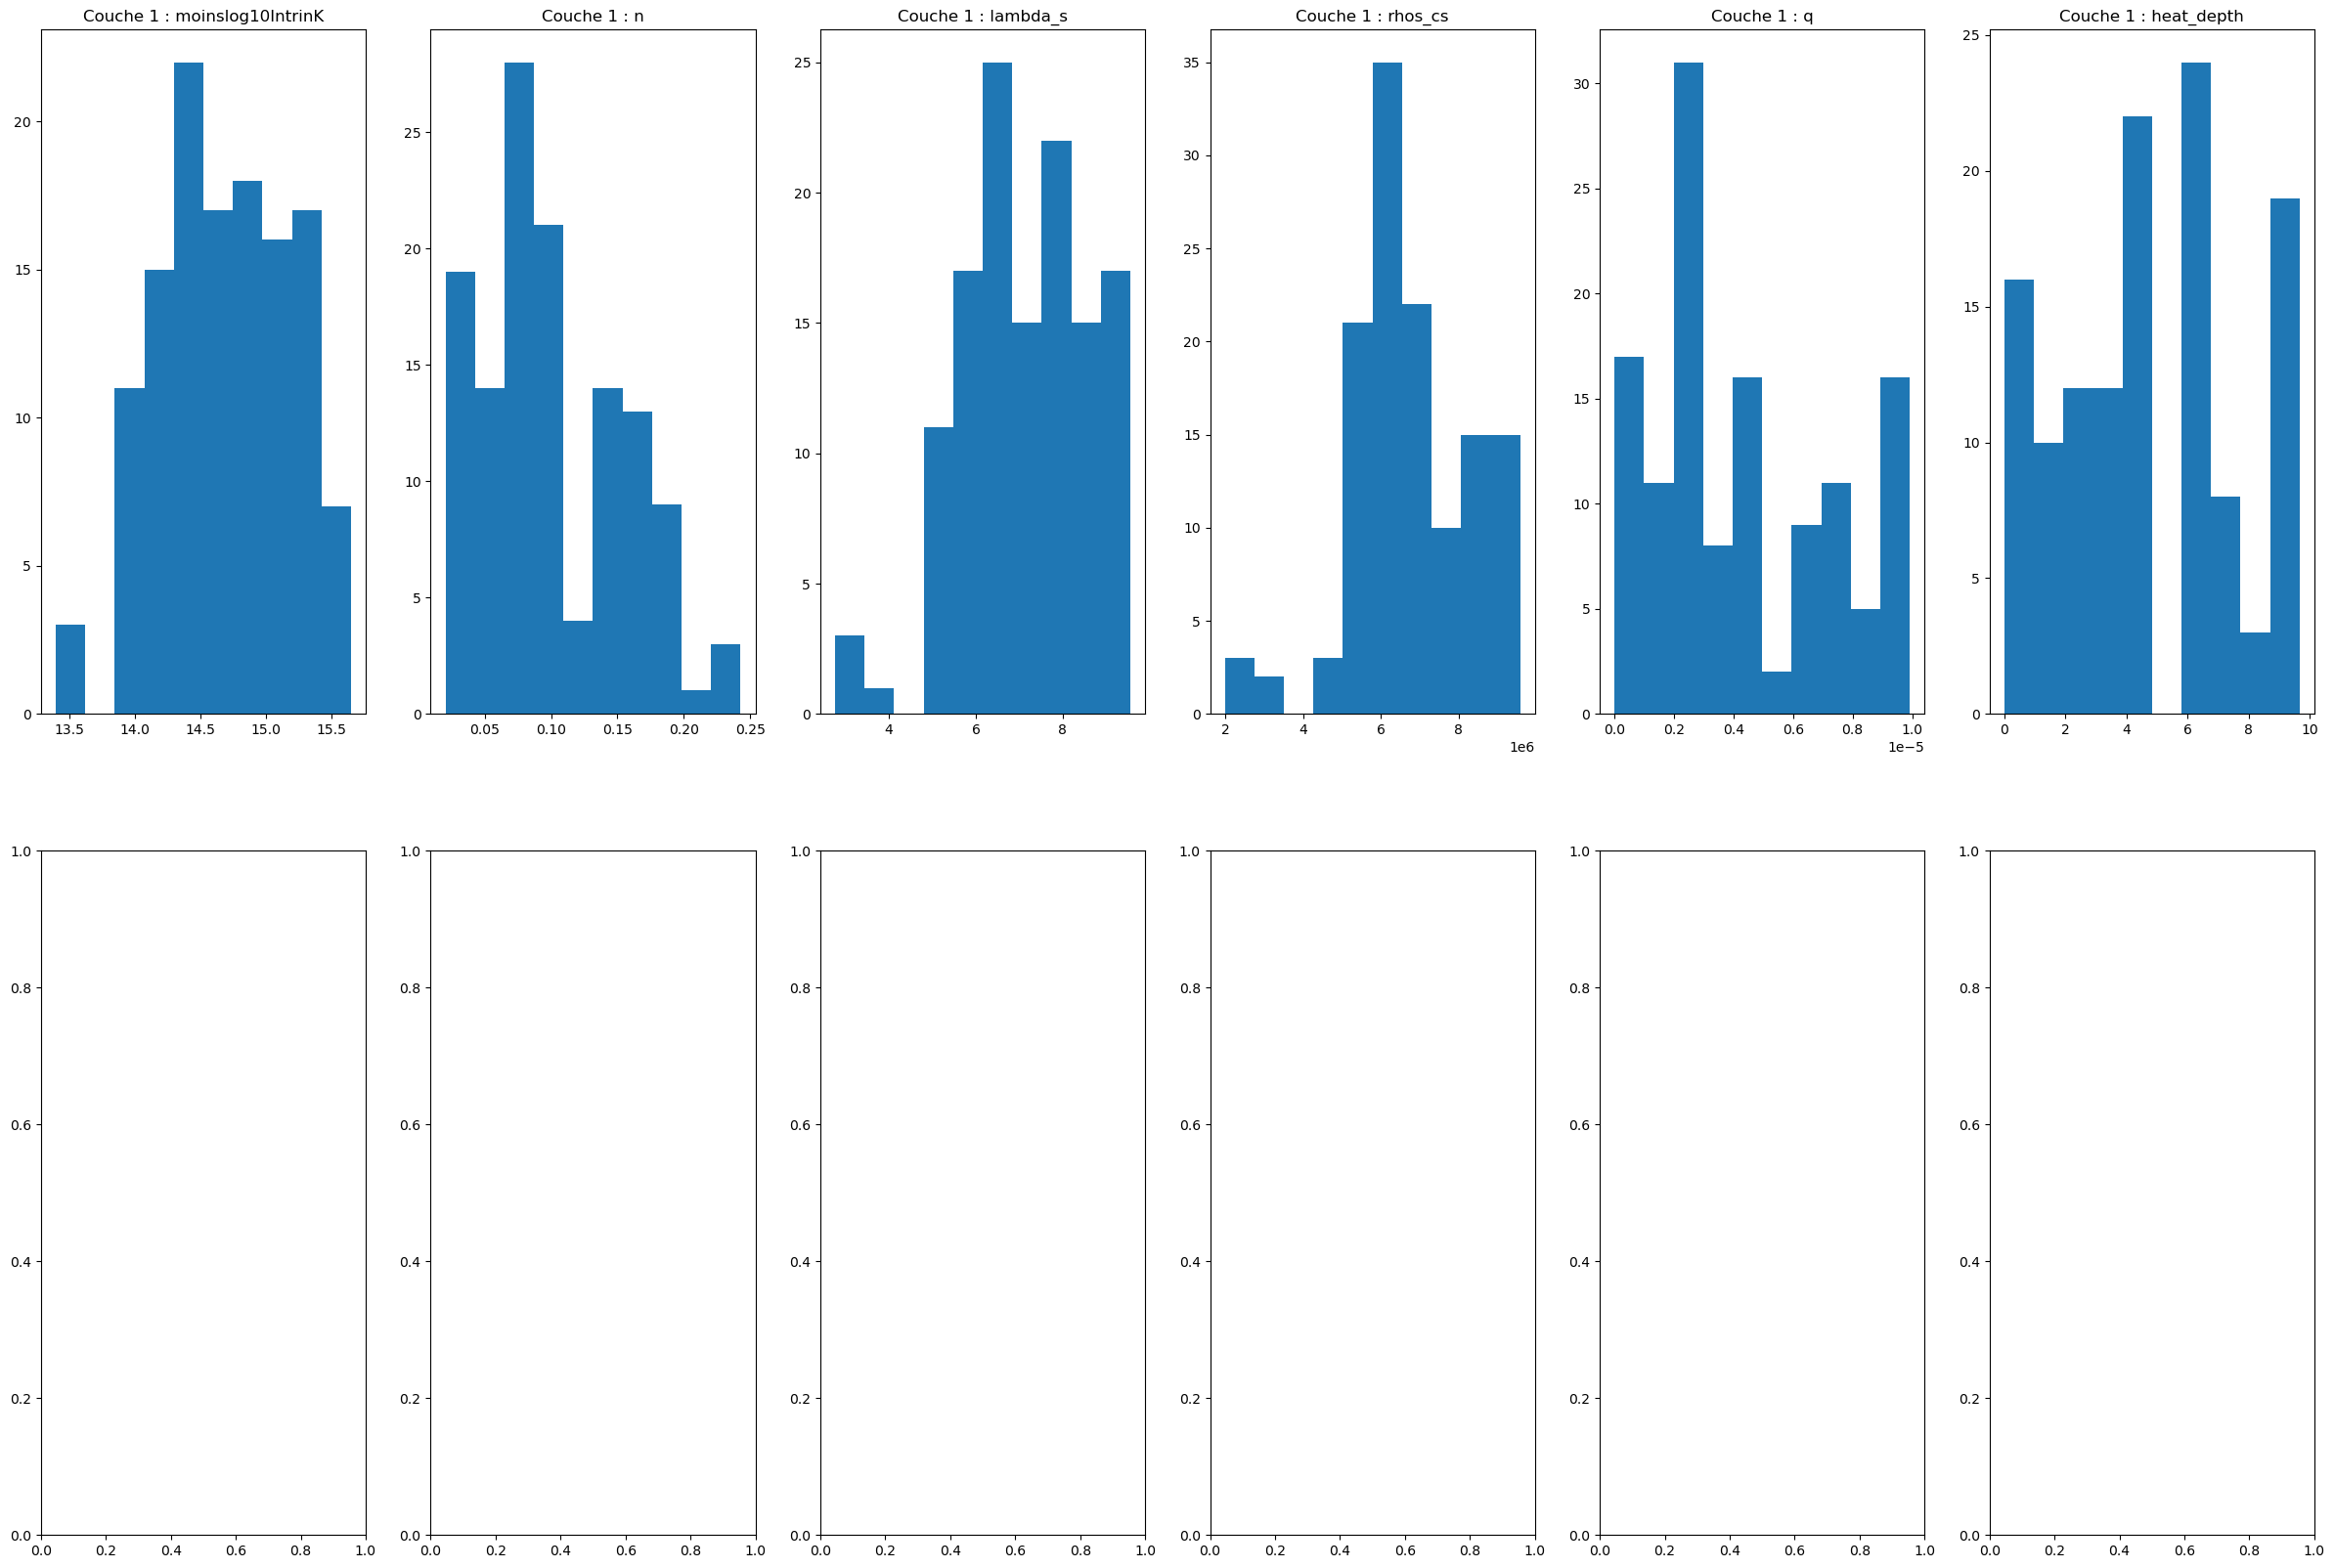

In [11]:
col.plot_all_param_pdf()


### 2.3 Quantiles

Une MCMC calcule aussi des quantiles de températures et de débits d'eau. On peut les récupérer de la façon suivante :

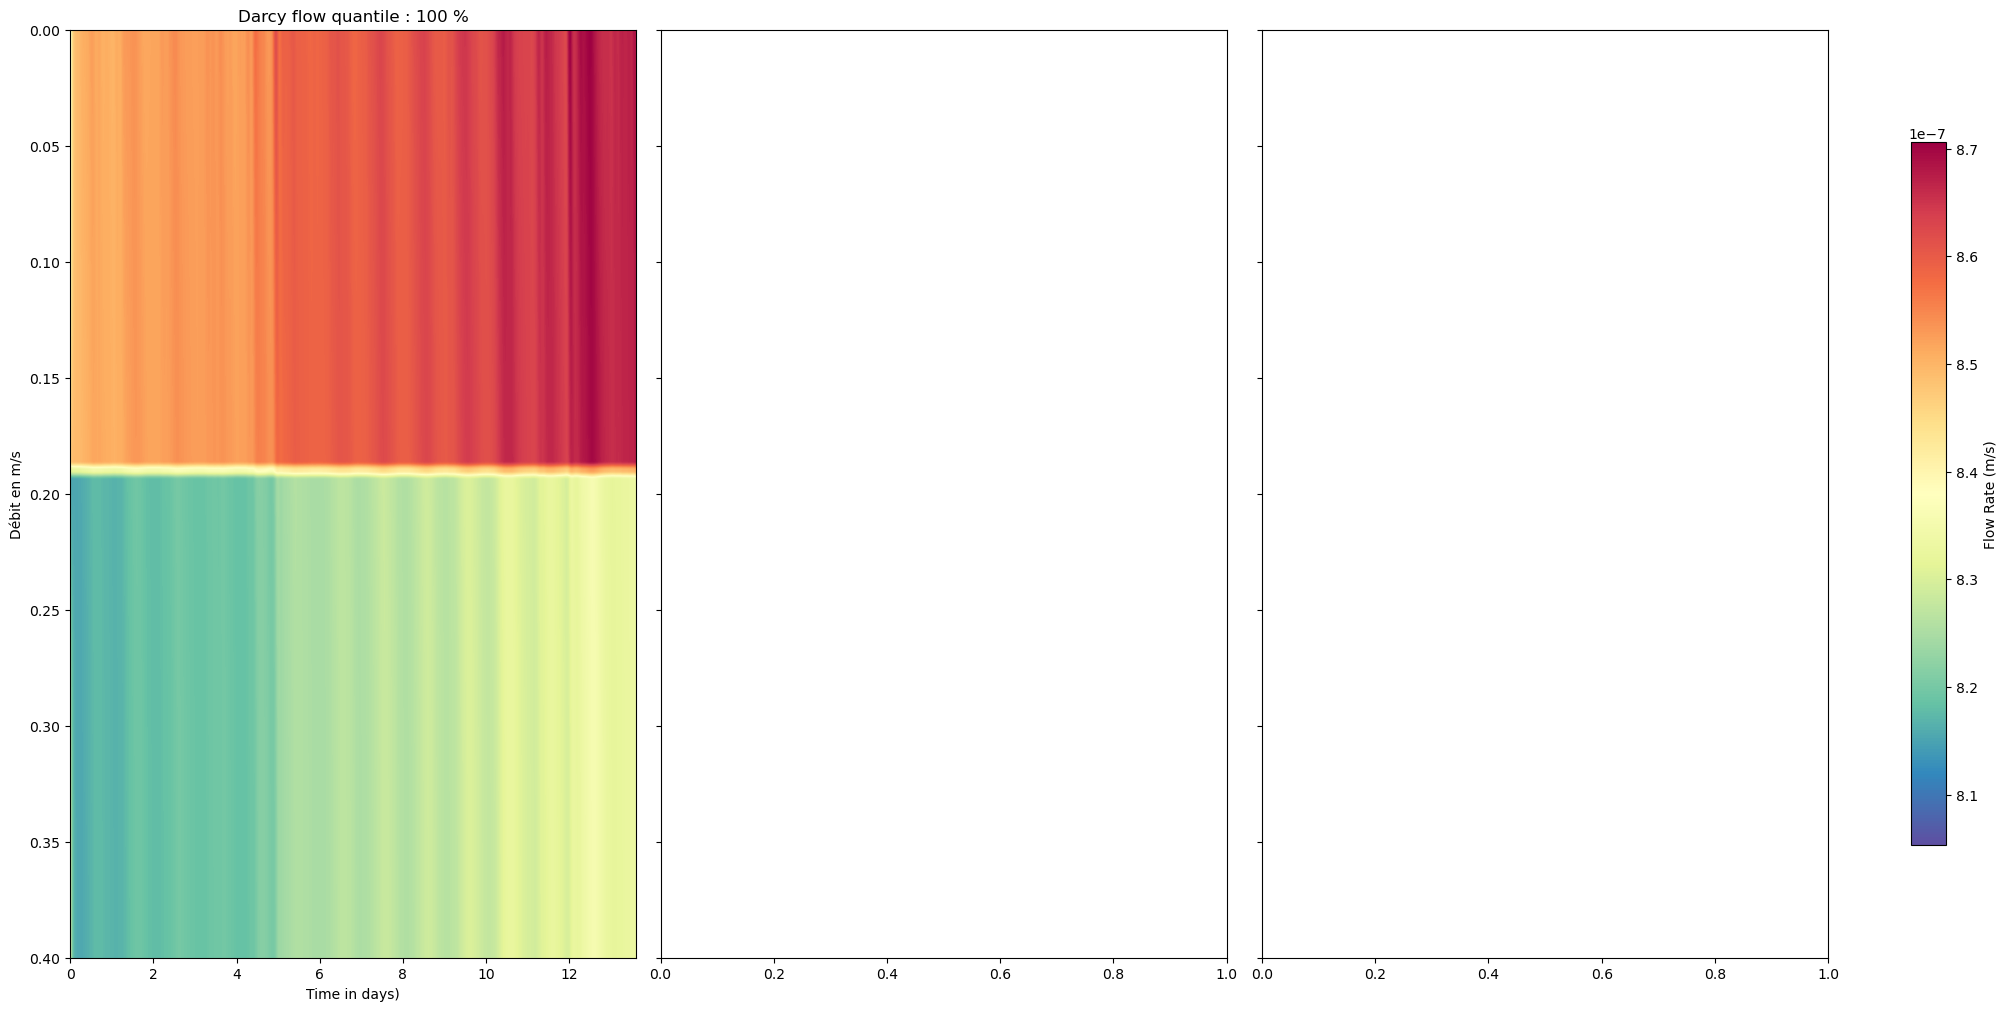

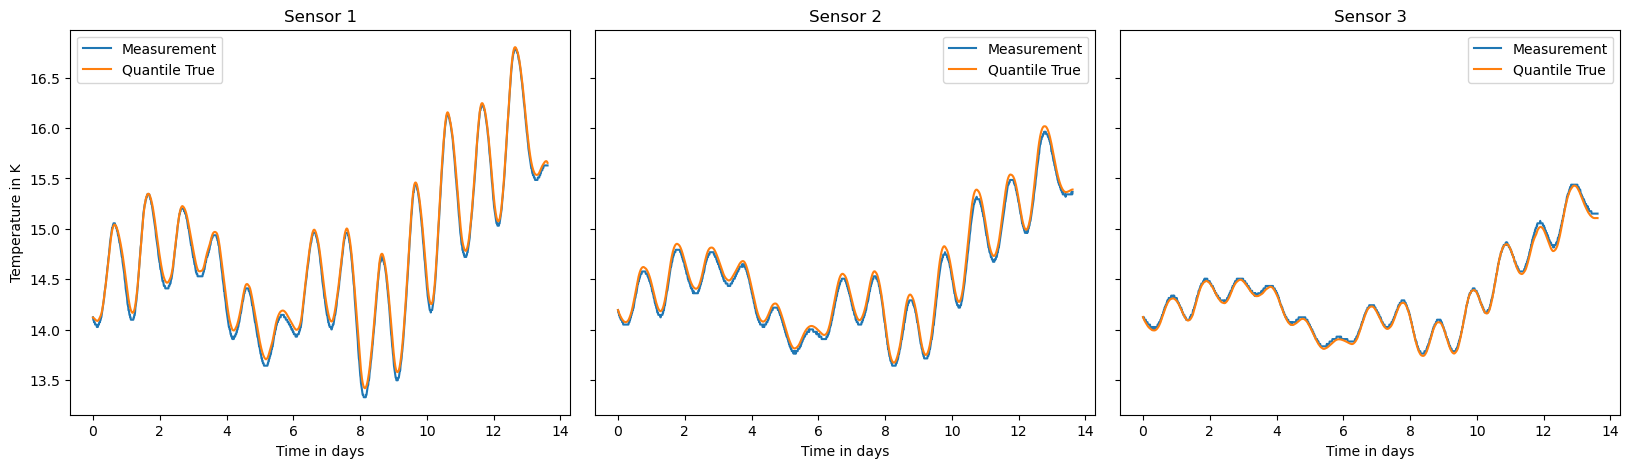

In [12]:
col.plot_darcy_flow_quantile()
col.plot_quantile_temperatures_sensors()

On peut aussi regarder les quantiles au niveau des capteurs, et comparer avec les mesures :

## 3. Multilayer Column

### 3.1. Direct Model

Pour une colonne stratifiée, on doit d'abord définir une liste d'objets ``Layer`` :

In [13]:
from pyheatmy.layers import layersListCreator

moinslog10IntrinK1 = 11
deltaK = 4
moinslog10IntrinK = moinslog10IntrinK + deltaK
Zinterface = 0.2
q = 1e-6
heat_depth = 5
layers_list = layersListCreator([("Couche 1", Zinterface, moinslog10IntrinK, n, lambda_s, rhos_cs, q, heat_depth), ("Couche 2", Zbottom, moinslog10IntrinK, n, lambda_s, rhos_cs, q,heat_depth)])

Puis on appelle le modèle direct :

RMSE at sensor 0 : 0.16191963790781042
RMSE at sensor 1 : 0.14050882780970472
RMSE at sensor 2 : 0.12398247934651985
Total RMSE : 0.14298293023710199


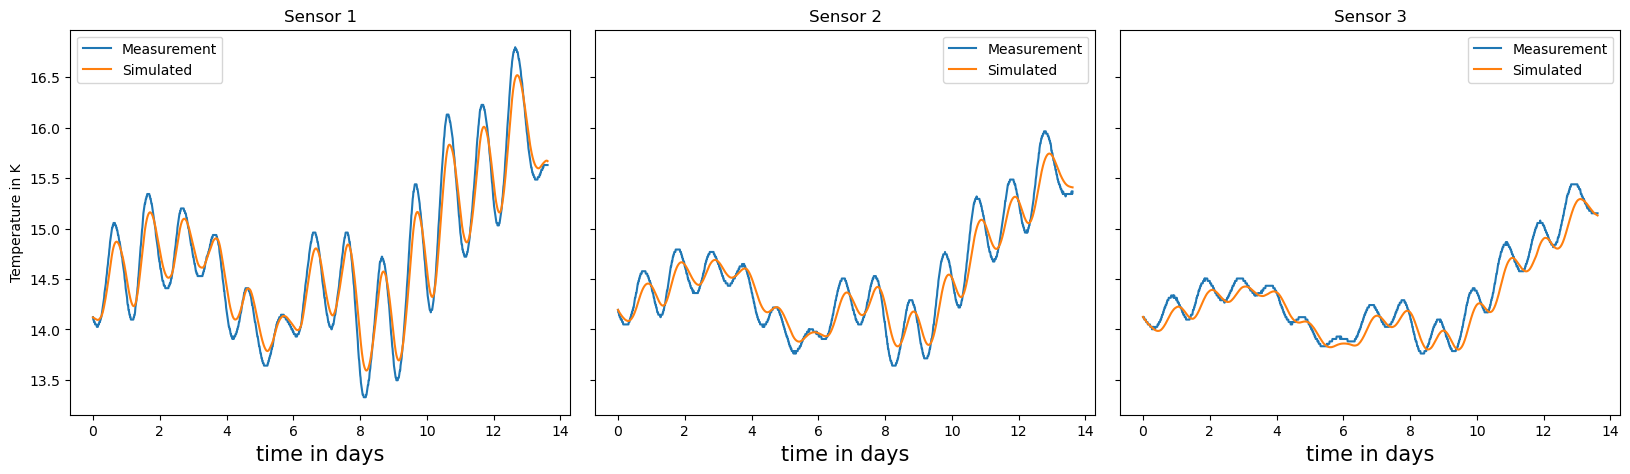

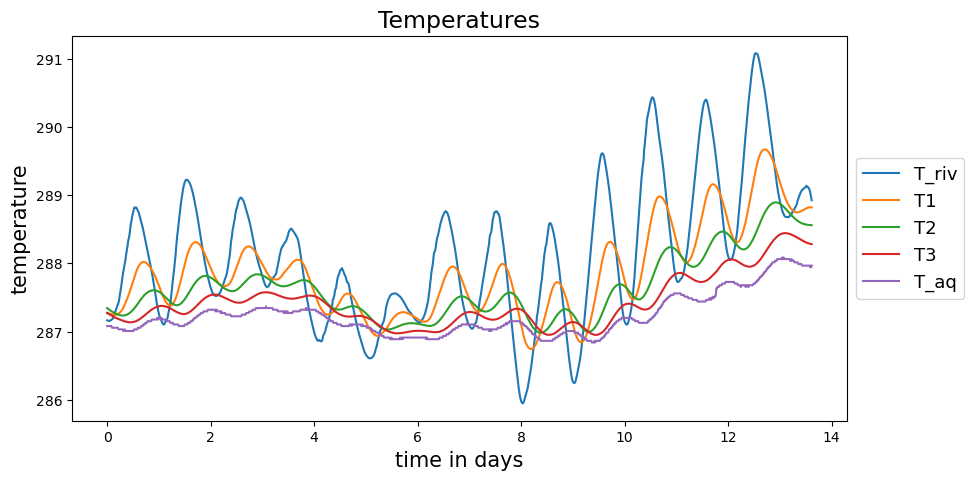

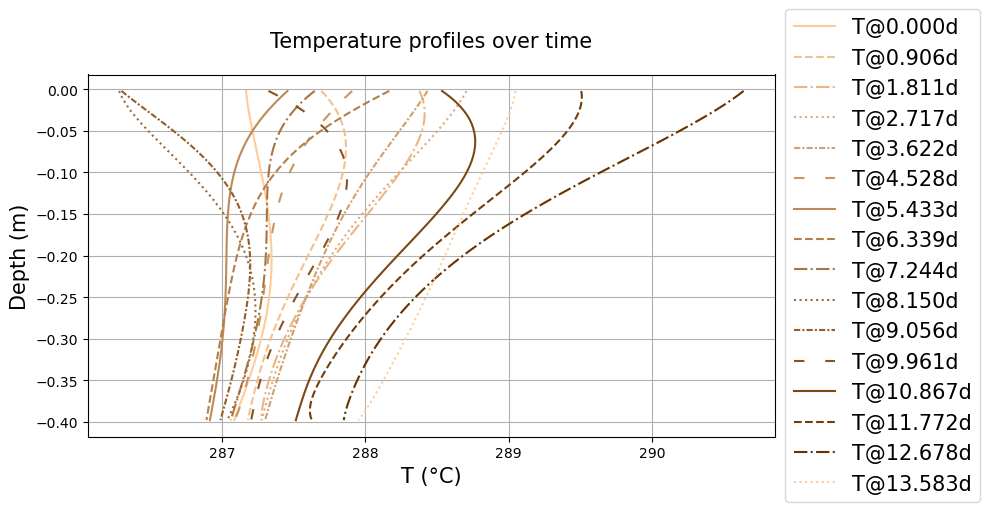

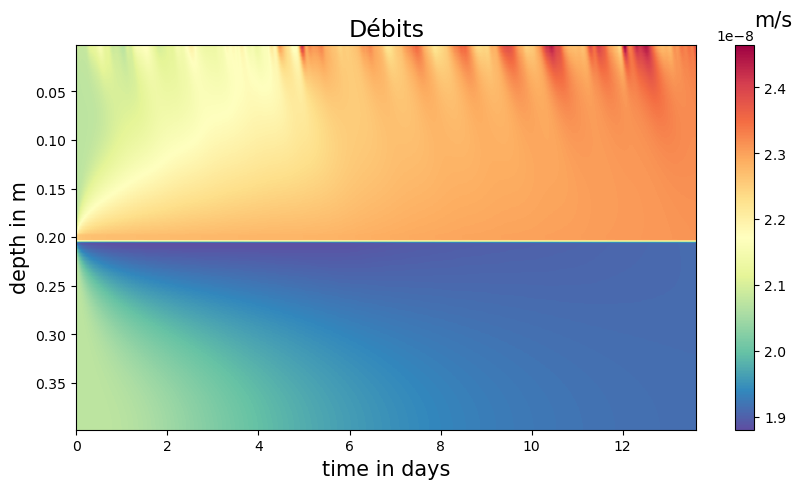

In [14]:
col.compute_solve_transi(layers_list,verbose=False)

col.print_RMSE_at_sensor()
col.plot_compare_temperatures_sensors()
col.plot_temperature_at_sensors()
nt = len(col._temperatures[0,:])
dplot=15
col.plot_temperatures_umbrella(round(nt/dplot))
flows = col.get_flows_solve()
unitLeg="m/s"
title="Débits"
col.plot_it_Zt(flows,title,unitLeg,1.04,2)

## 3.2 Inférence bayésienne

L'inférence bayésienne va nous permettre d'estimer une distribution a posteriori pour chaque paramètre.

### 3.2.1. MCMC sans estimation de l'erreur

On peut lancer une MCMC en gardant $\sigma^2$ constant. On définit des distributions a priori pour chaque couche :

In [15]:
priors_couche_1 = {
    "moinslog10IntrinK": ((4+7, 9+7), .01), # (intervalle, sigma)
    "n": ((.001, .25), .005),
    "lambda_s": ((1, 10), .1),
    "rhos_cs": ((1e6,1e7), 1e5),
    "q": ((1e-9, 1e-5), 1e-7),
    "heat_depth": ((1,8), 1)
}

priors_couche_2 = {
    "moinslog10IntrinK": ((4+7, 9+7), .01), # (intervalle, sigma)
    "n": ((.001, .25), .005),
    "lambda_s": ((1, 10), .1),
    "rhos_cs": ((1e6,1e7), 1e5),
    "q": ((1e-9, 1e-5), 1e-7),
    "heat_depth": ((1,8), 1)
}

all_priors = [
    ['Couche 1', Zinterface, priors_couche_1],
    ['Couche 2', Zbottom, priors_couche_2],
]

col.compute_mcmc(
    nb_iter = 50,
    all_priors = all_priors,
    sigma2=1.0,
    verbose=False
)

{'moinslog10IntrinK': ((11, 16), 0.01), 'n': ((0.001, 0.25), 0.005), 'lambda_s': ((1, 10), 0.1), 'rhos_cs': ((1000000.0, 10000000.0), 100000.0), 'q': ((1e-09, 1e-05), 1e-07), 'heat_depth': ((1, 8), 1)}
{'moinslog10IntrinK': ((11, 16), 0.01), 'n': ((0.001, 0.25), 0.005), 'lambda_s': ((1, 10), 0.1), 'rhos_cs': ((1000000.0, 10000000.0), 100000.0), 'q': ((1e-09, 1e-05), 1e-07), 'heat_depth': ((1, 8), 1)}
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
--- Compute DREAM MCMC ---
Priors :
    [Prior sur une valeure qui évolue entre 11 et 16, Prior sur une valeure qui évolue entre 0.001 et 0.25, Prior sur une valeure qui évolue entre 1 et 10, Prior sur une valeure qui évolue entre 1000000.0 et 10000000.0, Prior sur une valeure qui évolue entre 1e-09 et 1e-05, Prior sur une valeure qui évolue entre 1 et 8]
    [Prior sur une valeure qui évolue entre 11 et 16, Prior sur une valeure qui évolue entre 0.001 et 0.25, Prior sur une valeure qui évolue entre 1 et 10, Prior sur une valeure qui évolue entre 100

Burn in phase: 100%|██████████| 50/50 [02:17<00:00,  2.75s/it]


Initialisation post burn-in - Utilisation de la mémoire (en Mo) : 290.246656
DREAM MCMC Computation: 100%|██████████| 50/50 [03:22<00:00,  4.05s/it]
Fin itérations MCMC, avant le calcul des quantiles - Utilisation de la mémoire (en Mo) : 321.544192
Quantiles computed


#### Recupération et affichage des distributions

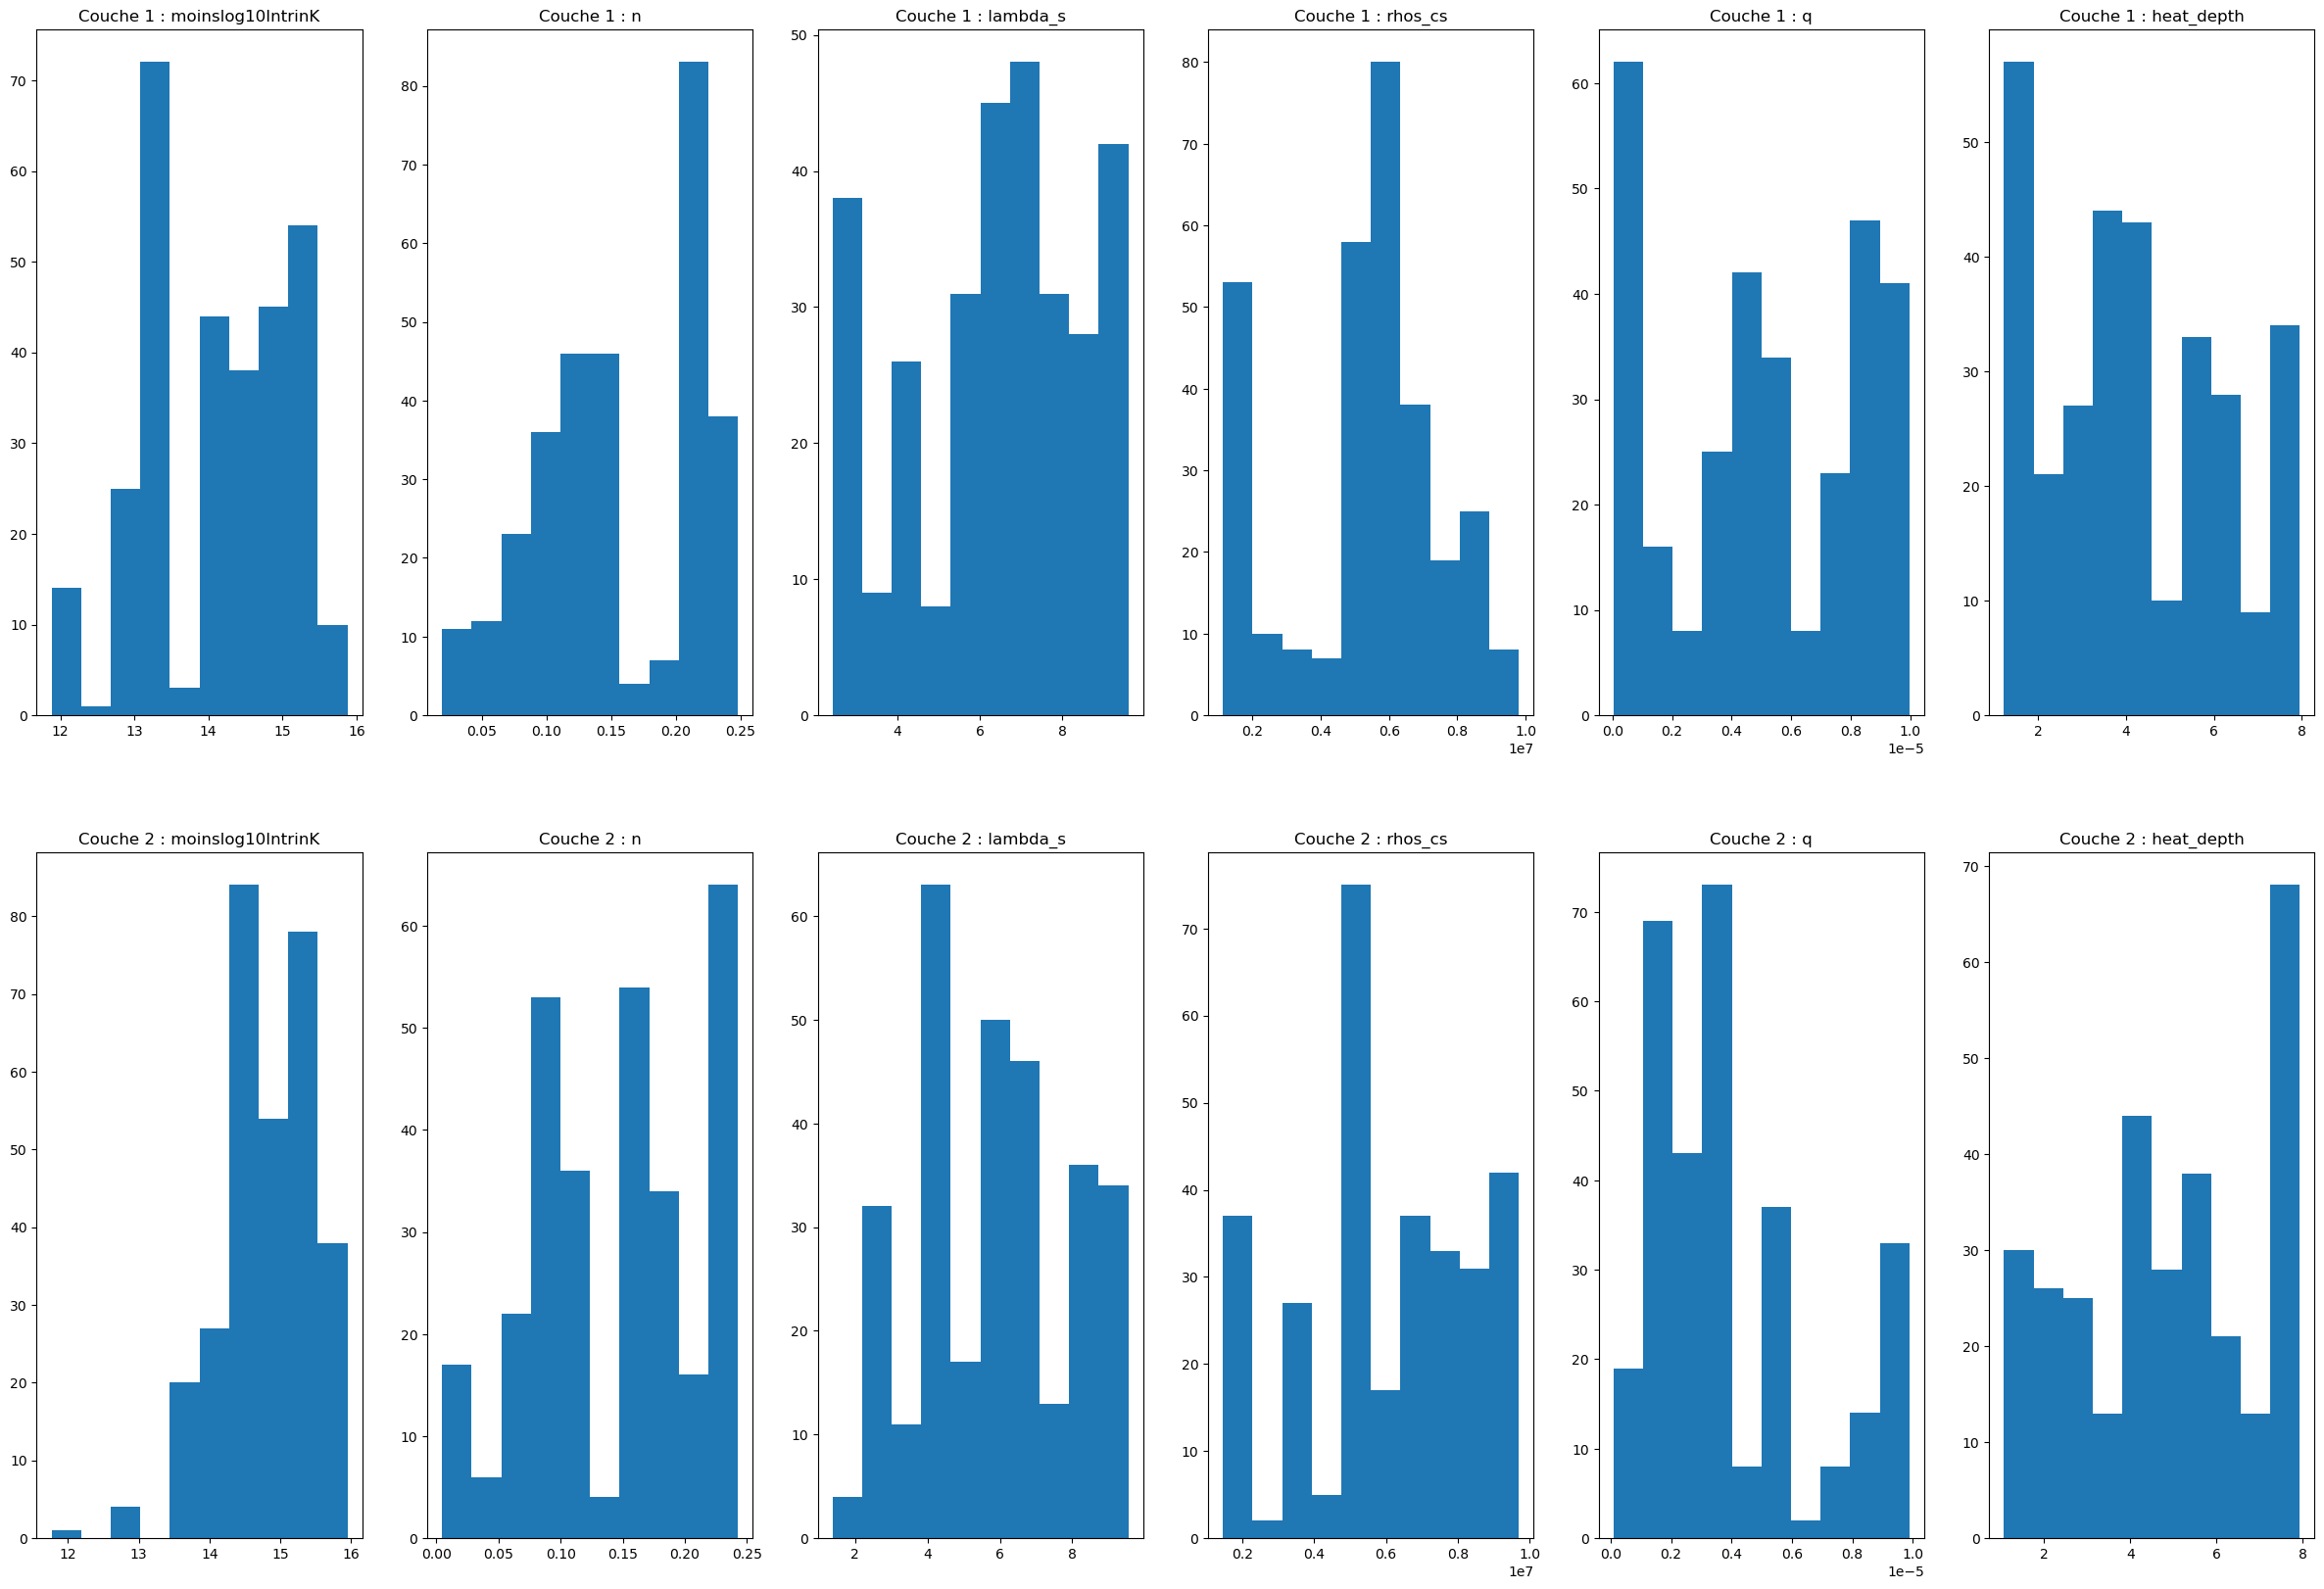

In [16]:
col.plot_all_param_pdf()

RMSE at sensor 0 : 0.03350148340604126
RMSE at sensor 1 : 0.026413151811639154
RMSE at sensor 2 : 0.04213660545003864
Total RMSE : 0.03461934670037444


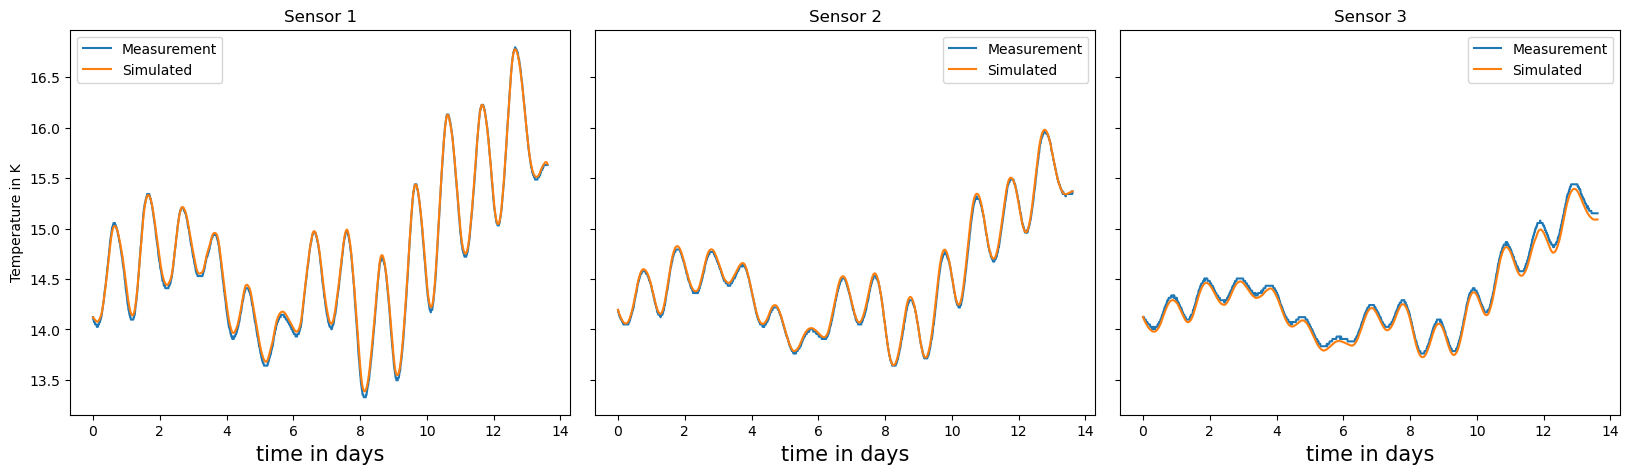

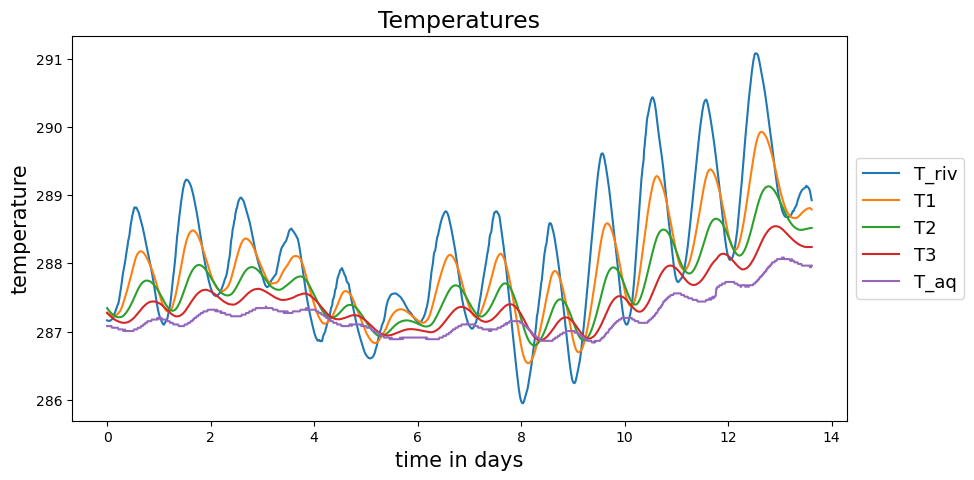

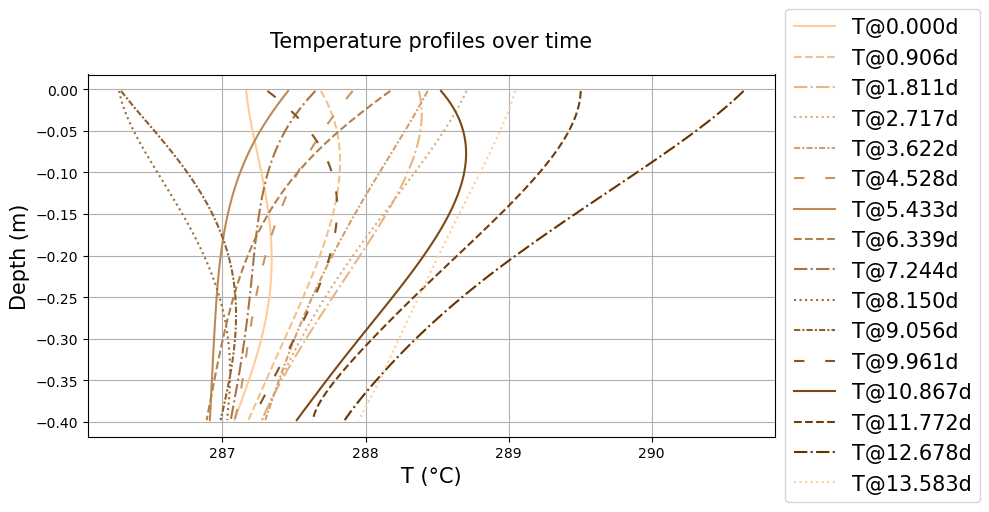

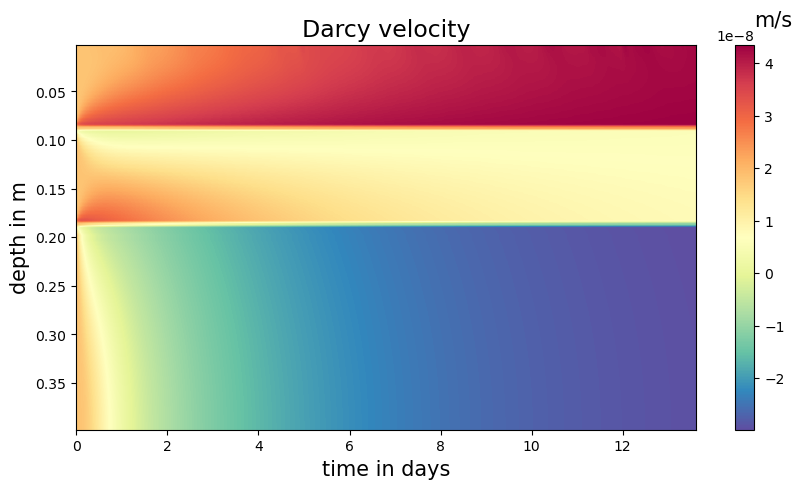

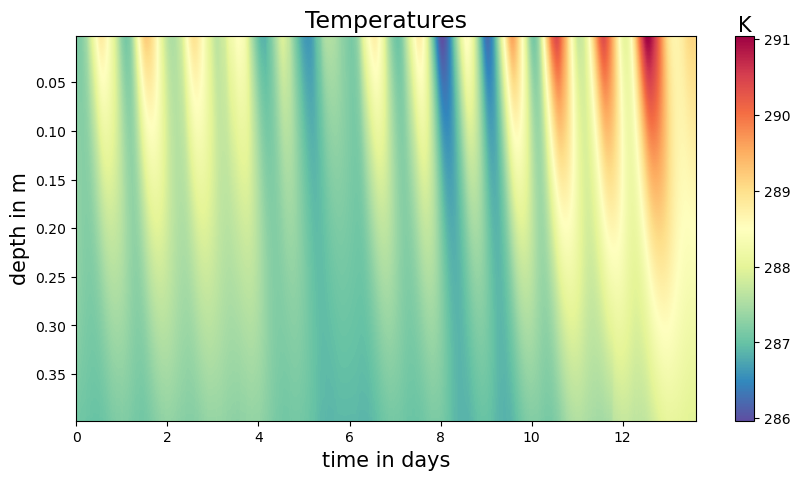

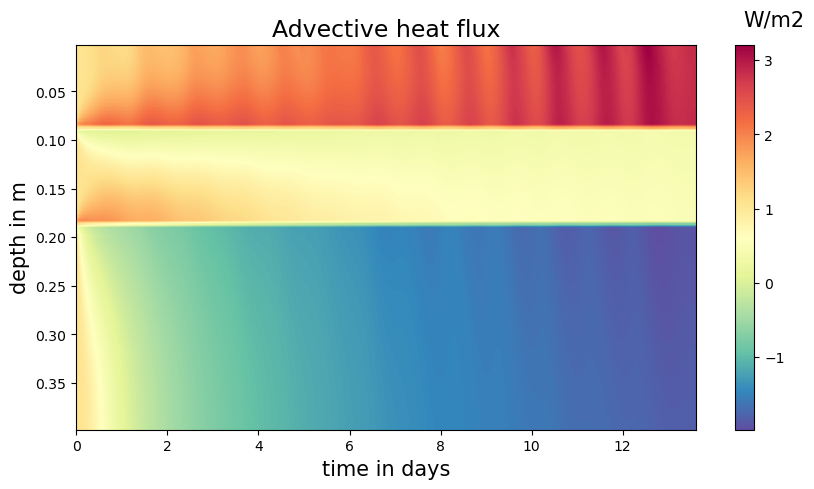

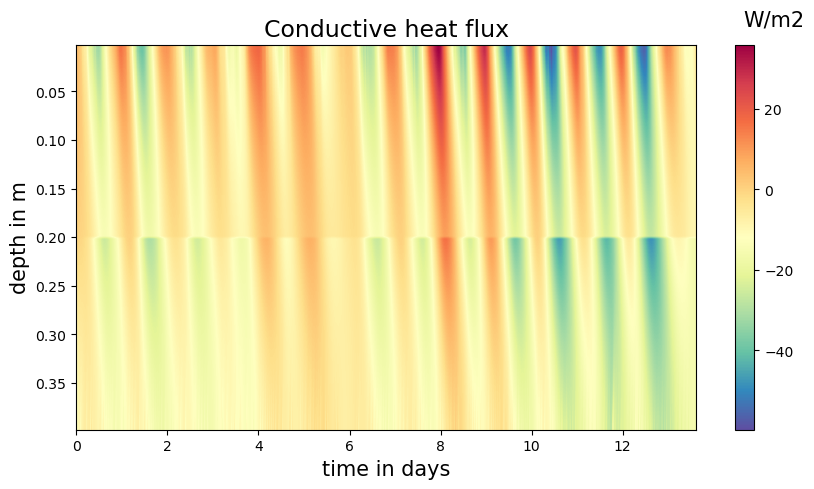

Plotting Température in column. time series have nrecords =  1309


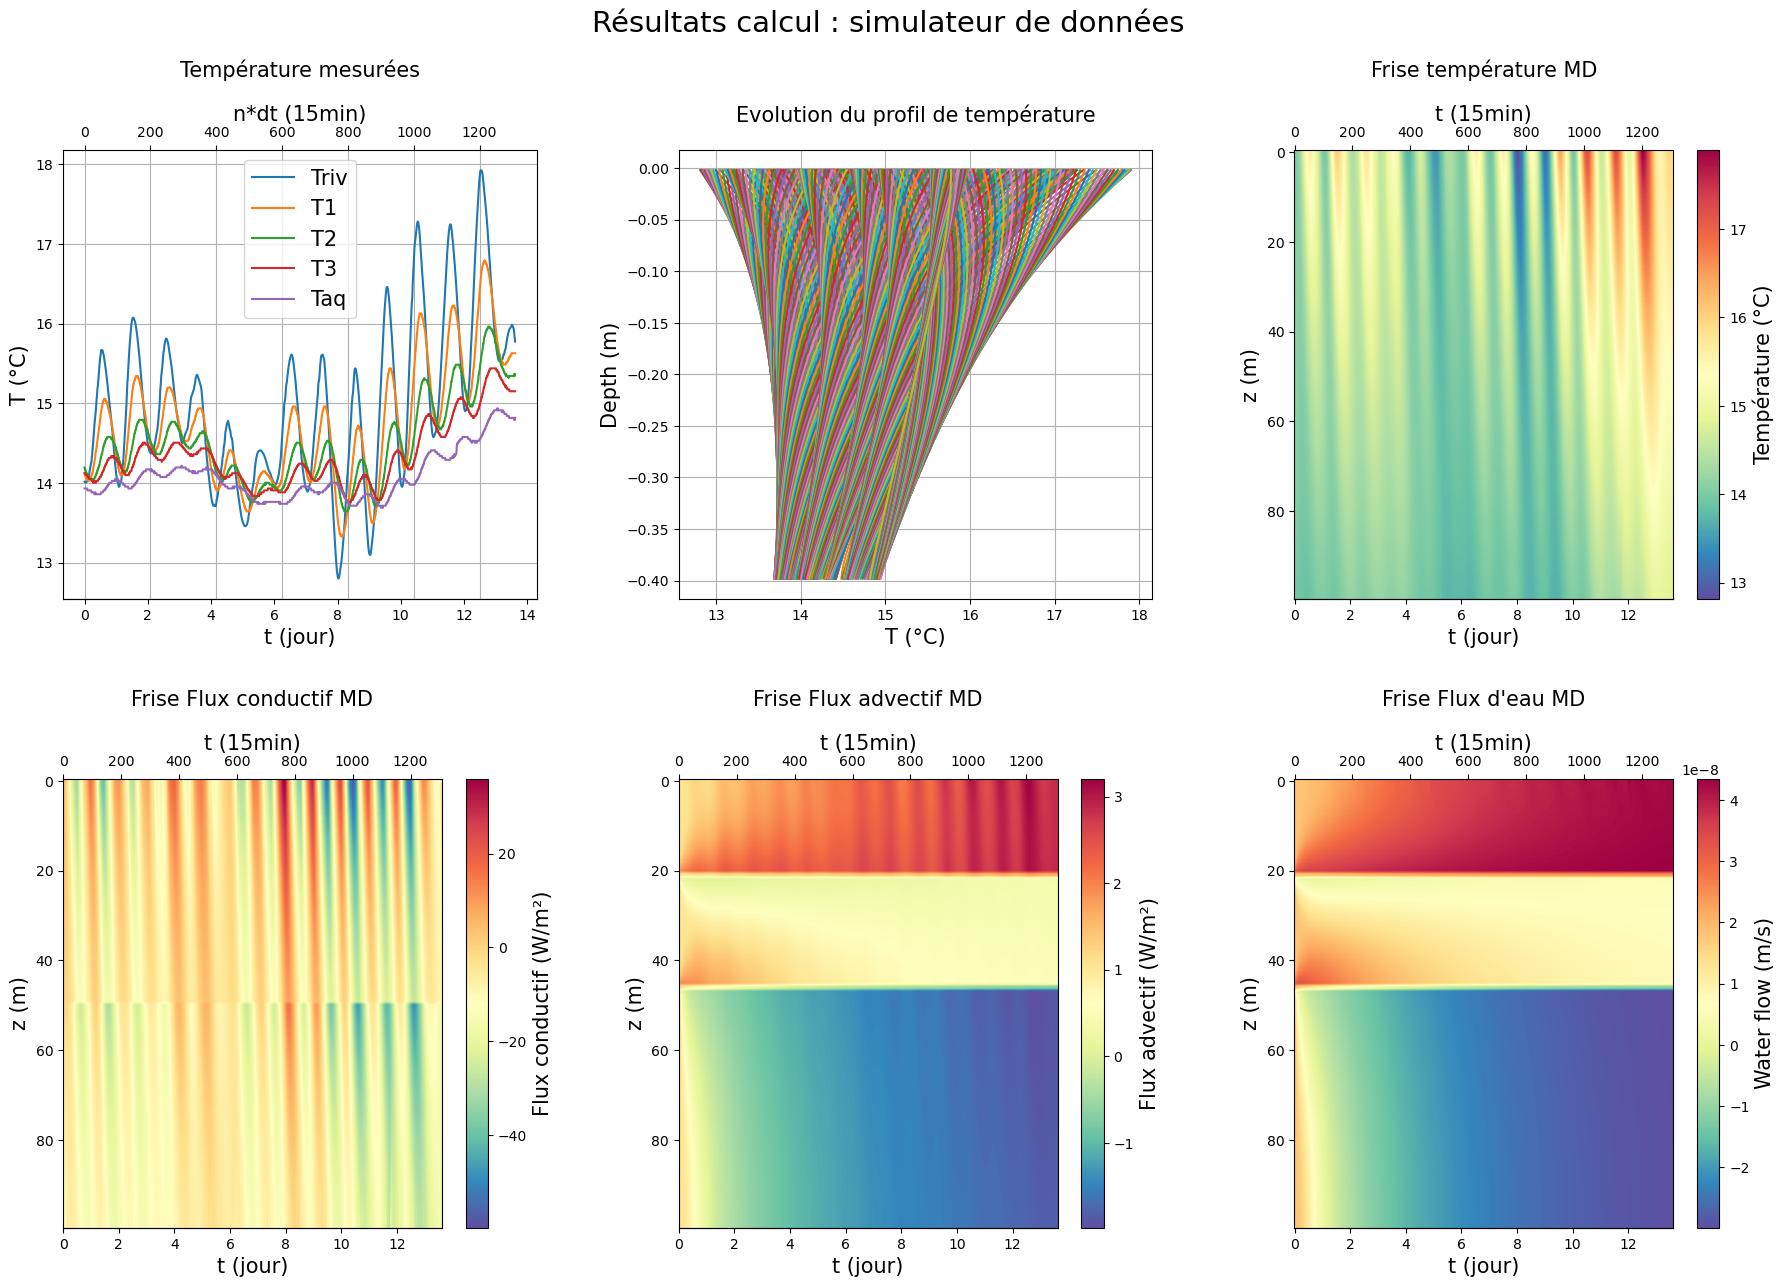

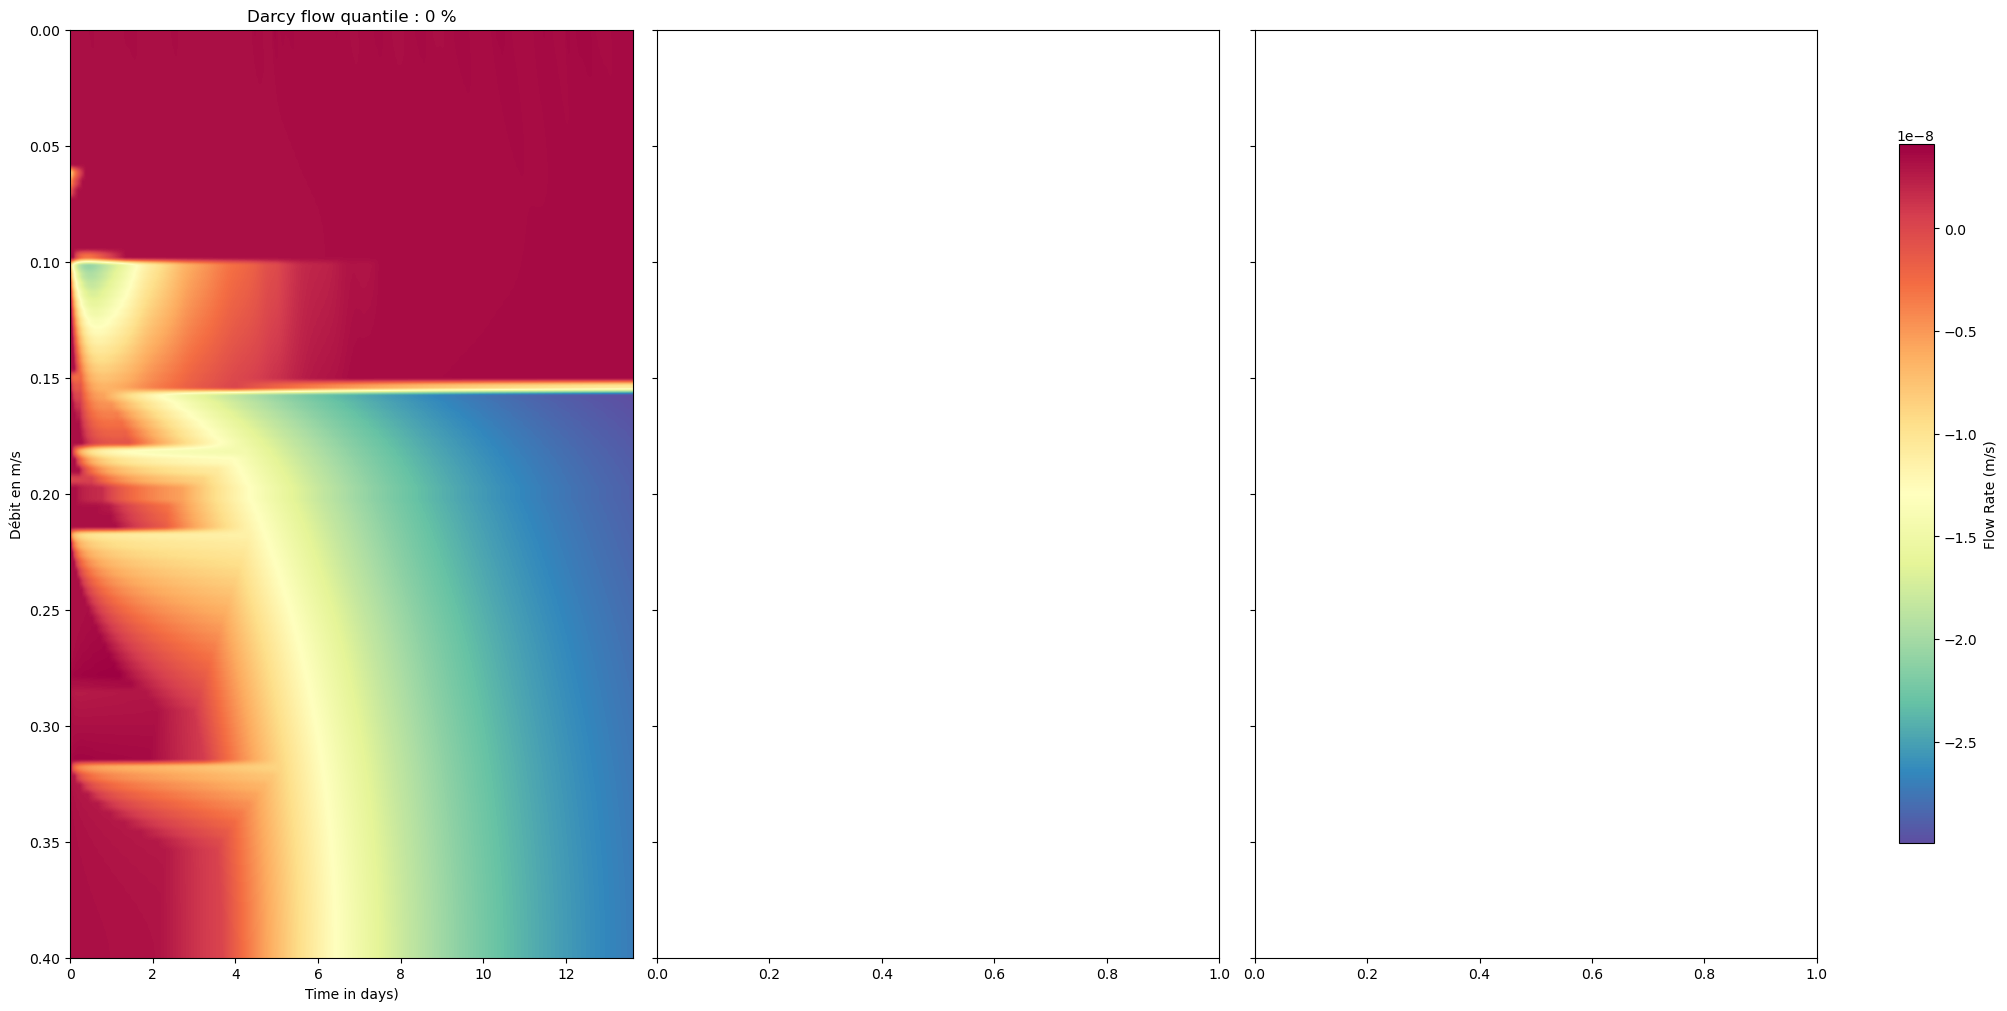

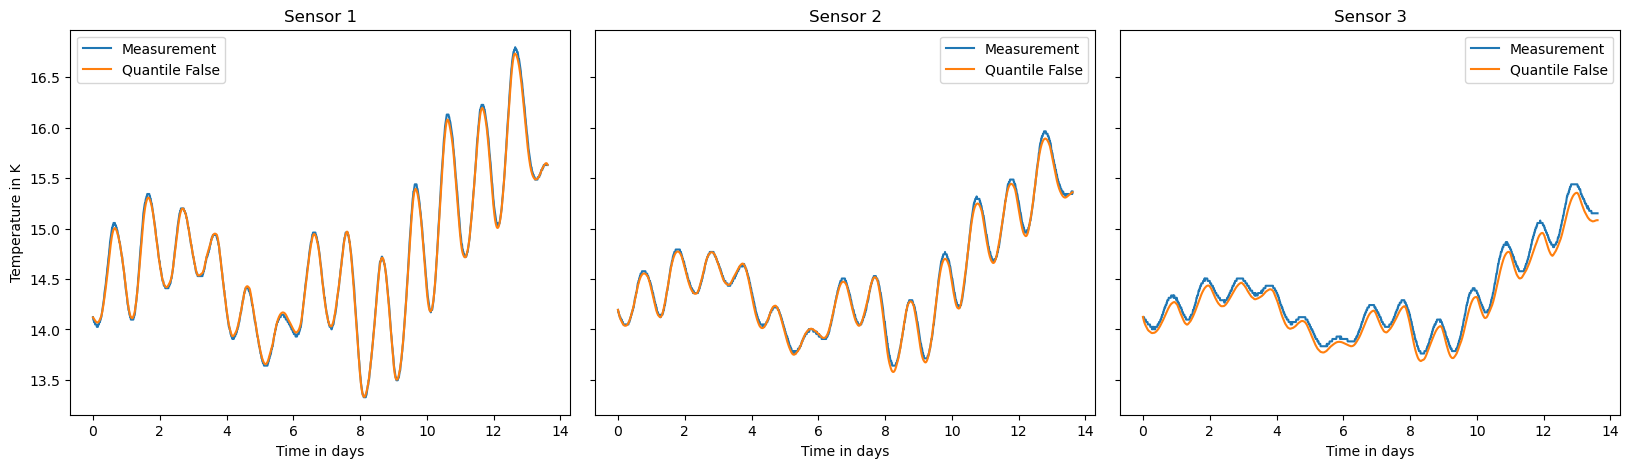

In [17]:
bestLayers = col.get_best_layers()
col.compute_solve_transi(bestLayers,verbose=False)
col.plot_all_results()
col.plot_darcy_flow_quantile()
col.plot_quantile_temperatures_sensors()

#### Options : Récupération d'autres paramètres
Voici les un exemple de paramètres qui, normalement, sont bons :

In [18]:
otherGoodLayers = layersListCreator([("Couche 1", 0.20, 7.915378861204348, 0.1310721719612464, 5.602951622531522, 4758163.582292321, 1e-6,7),
("Couche 2", 0.40, 6.574103692603533, 0.029547616319484868, 3.944439207155854, 4931216.13398901, 1e-7, 3)]) # q=1 pour le moment

#### 3.2.3 MCMC avec estimation de l'erreur

Pour lancer une MCMC avec estimation de la distribution de $\sigma^2$, il suffit d'ajouter une distribution a priori sur ce paramètre. On utilise pour cela la classe ``Prior``, qui est initialisée avec :
- un tuple pour l'intervalle dans lequel le paramètre varie
- un écart type pour la marche aléatoire
- une densité

{'moinslog10IntrinK': ((11, 16), 0.01), 'n': ((0.001, 0.25), 0.005), 'lambda_s': ((1, 10), 0.1), 'rhos_cs': ((1000000.0, 10000000.0), 100000.0), 'q': ((1e-09, 1e-05), 1e-07), 'heat_depth': ((1, 8), 1)}
{'moinslog10IntrinK': ((11, 16), 0.01), 'n': ((0.001, 0.25), 0.005), 'lambda_s': ((1, 10), 0.1), 'rhos_cs': ((1000000.0, 10000000.0), 100000.0), 'q': ((1e-09, 1e-05), 1e-07), 'heat_depth': ((1, 8), 1)}
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
--- Compute DREAM MCMC ---
Priors :
    [Prior sur une valeure qui évolue entre 11 et 16, Prior sur une valeure qui évolue entre 0.001 et 0.25, Prior sur une valeure qui évolue entre 1 et 10, Prior sur une valeure qui évolue entre 1000000.0 et 10000000.0, Prior sur une valeure qui évolue entre 1e-09 et 1e-05, Prior sur une valeure qui évolue entre 1 et 8]
    [Prior sur une valeure qui évolue entre 11 et 16, Prior sur une valeure qui évolue entre 0.001 et 0.25, Prior sur une valeure qui évolue entre 1 et 10, Prior sur une valeure qui évolue entre 100

Burn in phase: 100%|██████████| 50/50 [02:09<00:00,  2.59s/it]


Initialisation post burn-in - Utilisation de la mémoire (en Mo) : 326.086656
DREAM MCMC Computation: 100%|██████████| 50/50 [03:09<00:00,  3.79s/it]
Fin itérations MCMC, avant le calcul des quantiles - Utilisation de la mémoire (en Mo) : 357.4784
Quantiles computed
RMSE at sensor 0 : 0.03358465190975073
RMSE at sensor 1 : 0.026403065606931078
RMSE at sensor 2 : 0.042344774494982626
Total RMSE : 0.03472813770020866


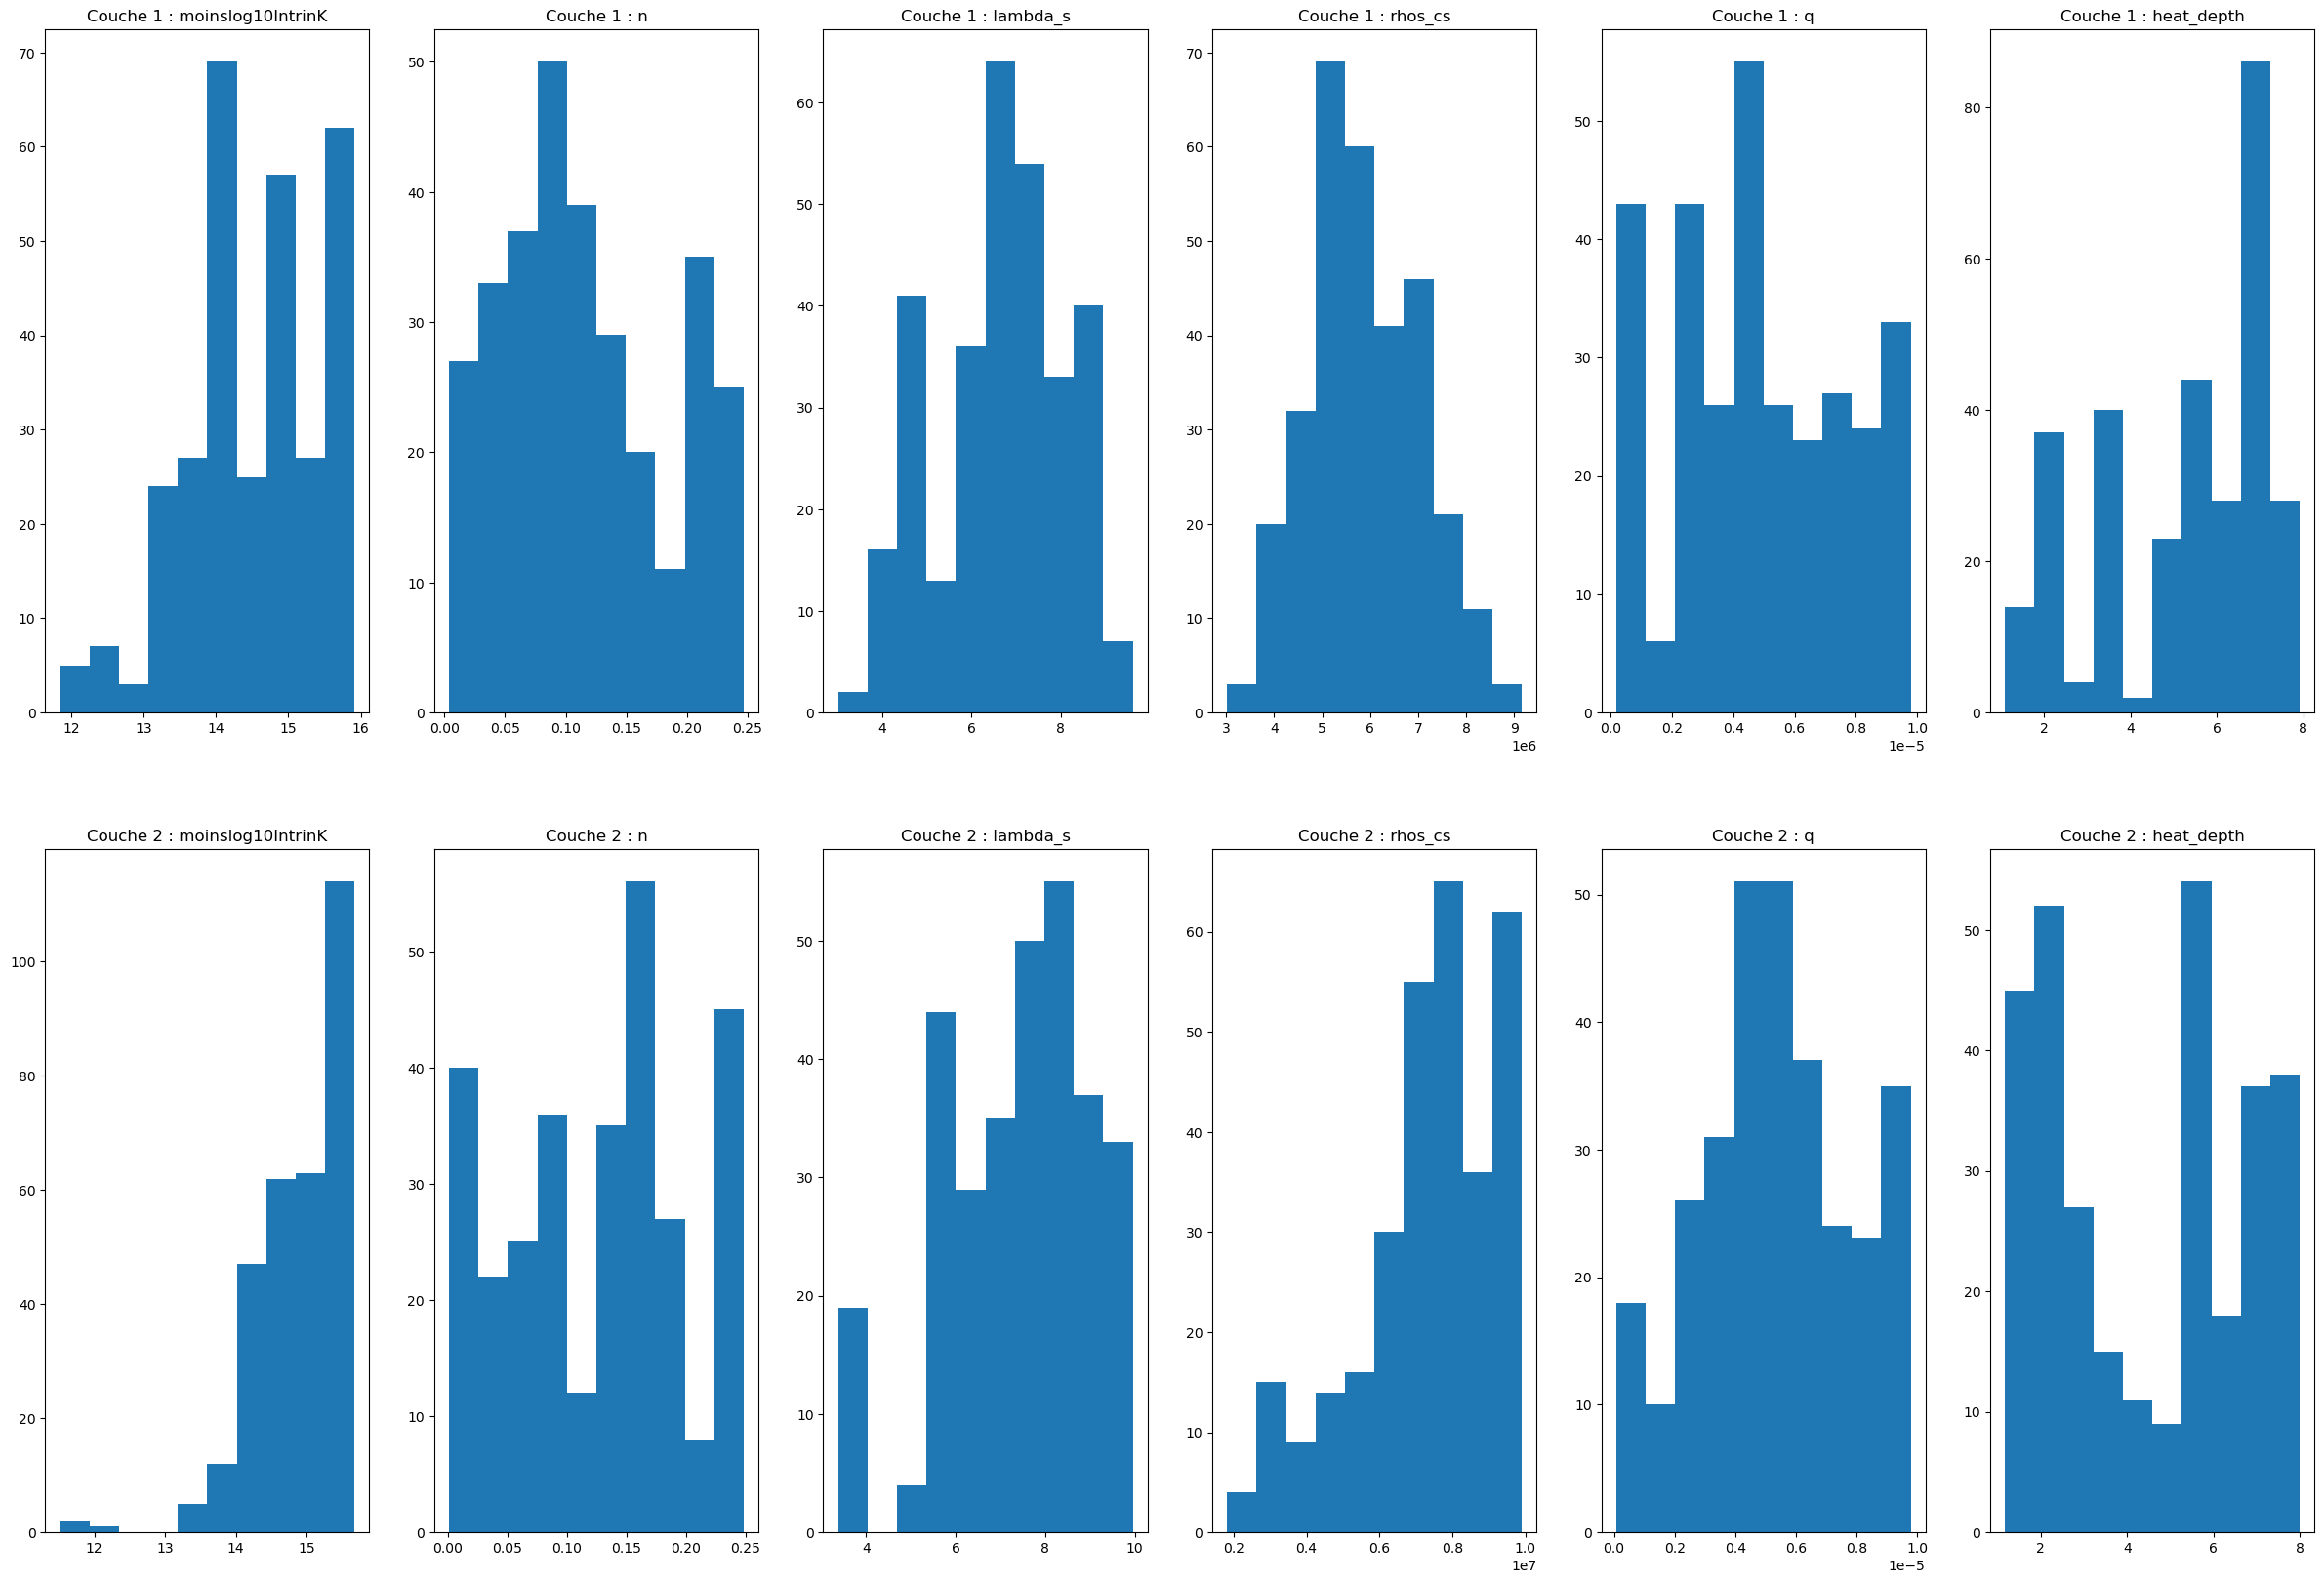

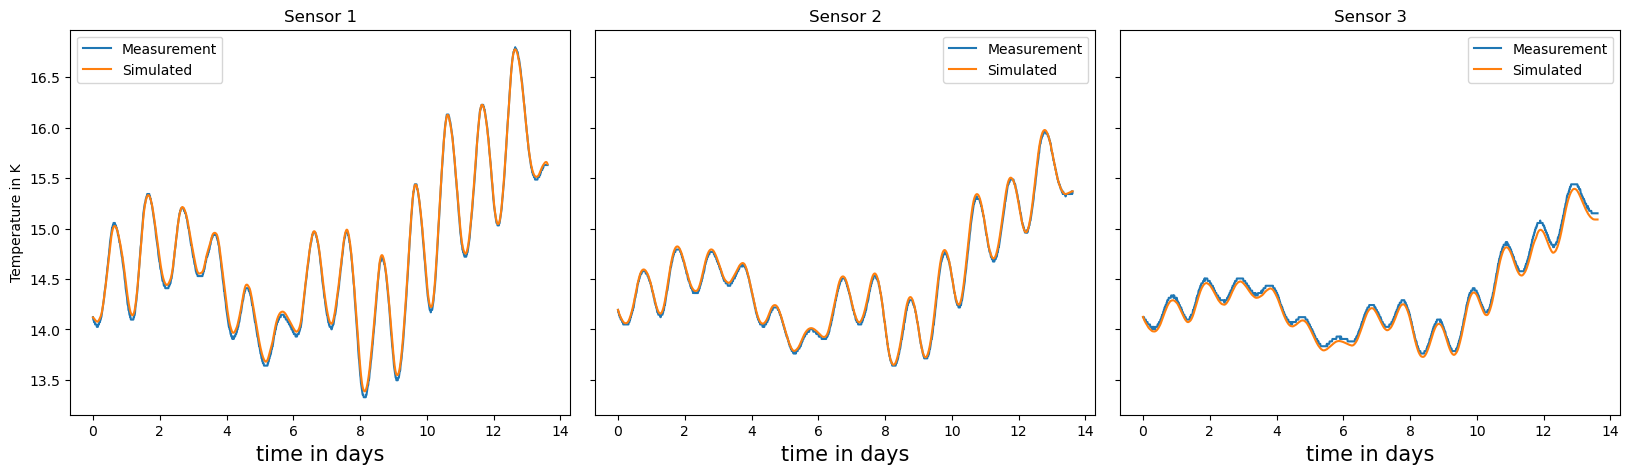

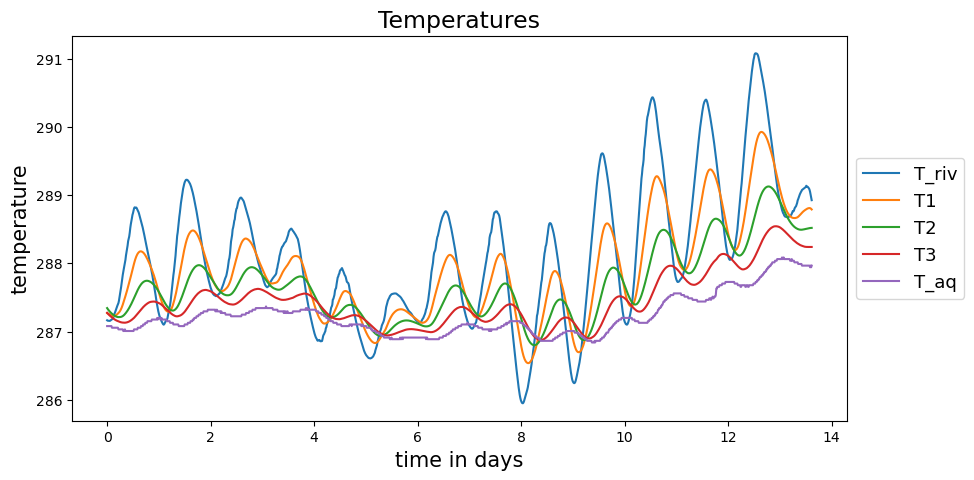

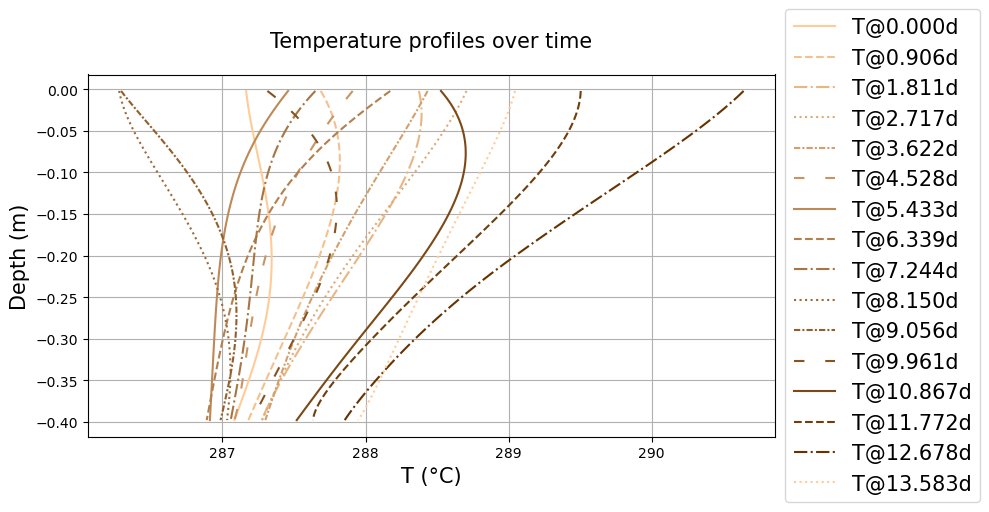

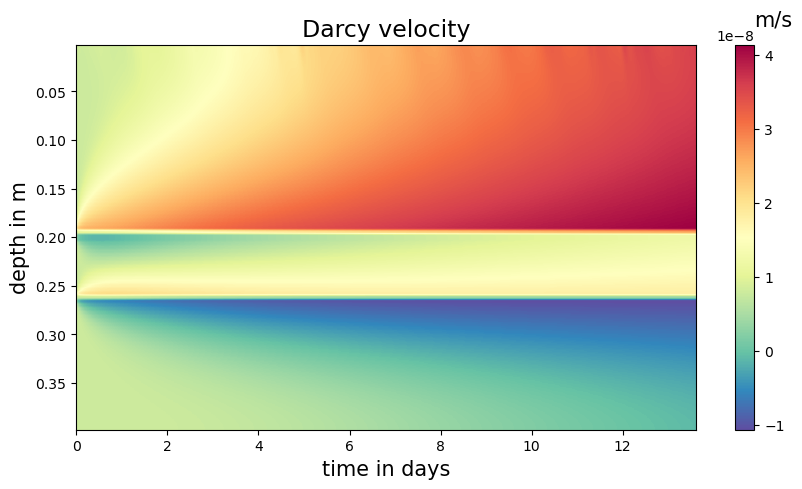

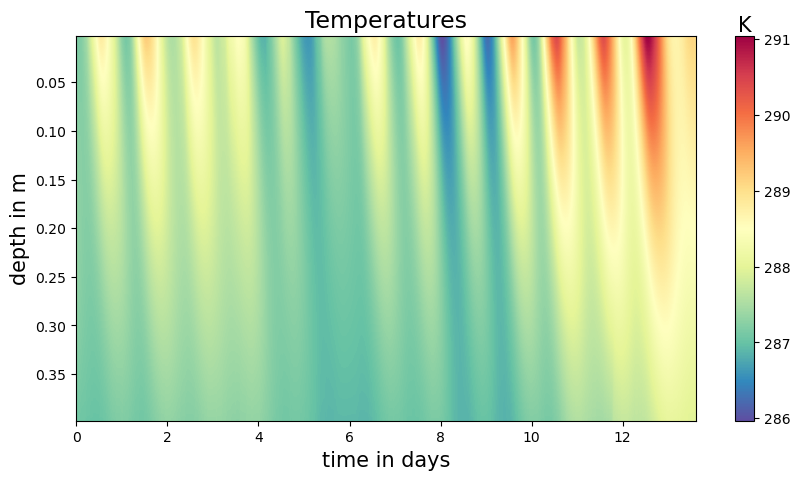

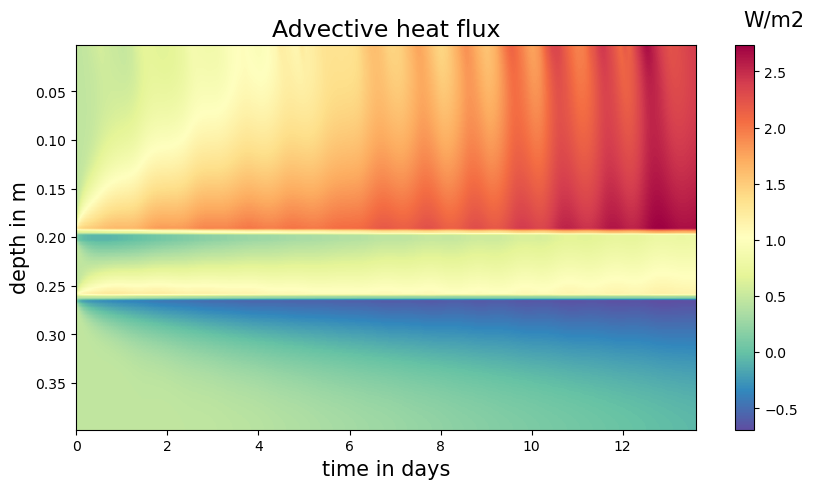

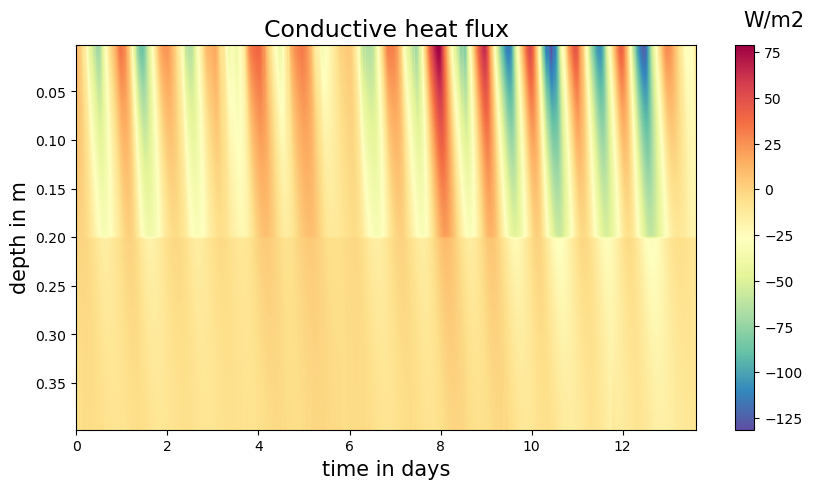

Plotting Température in column. time series have nrecords =  1309


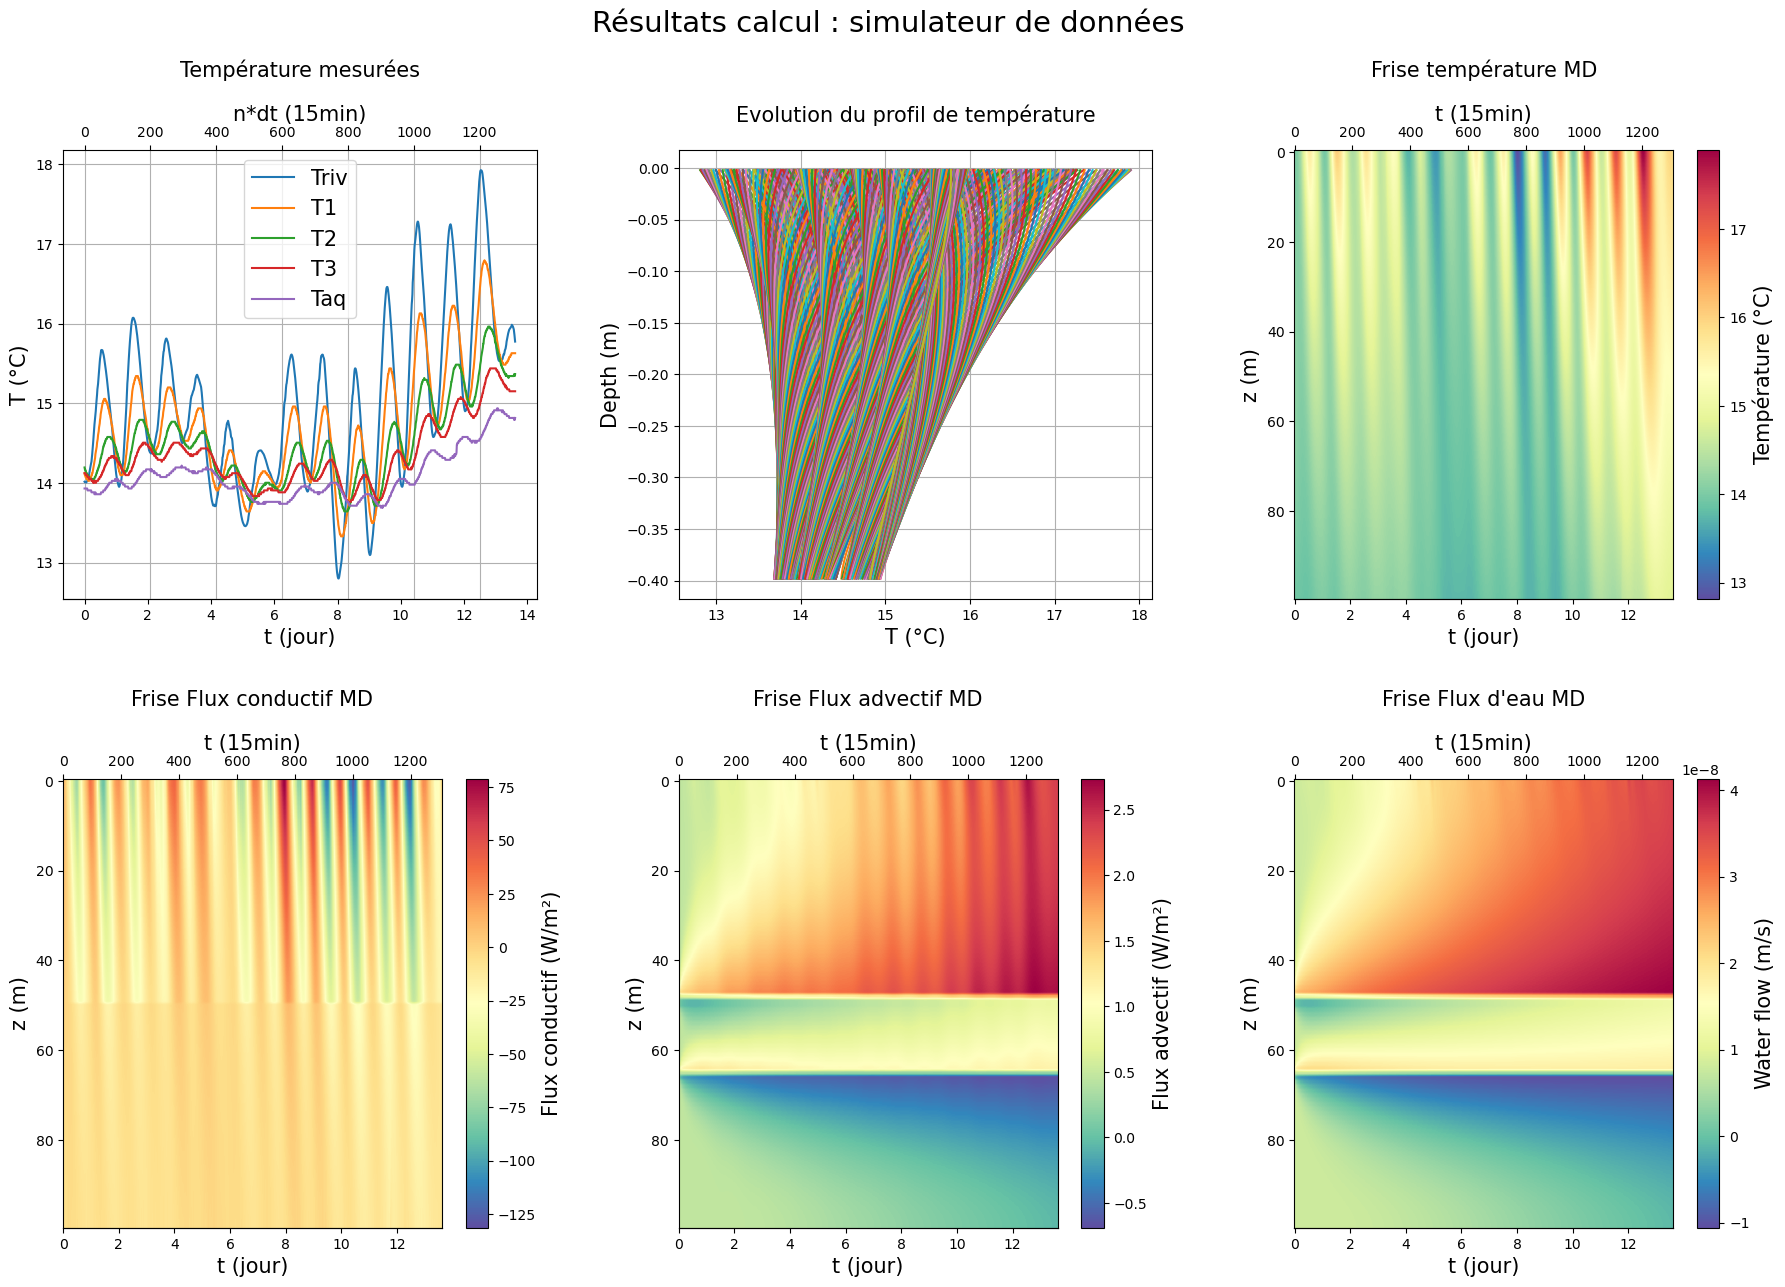

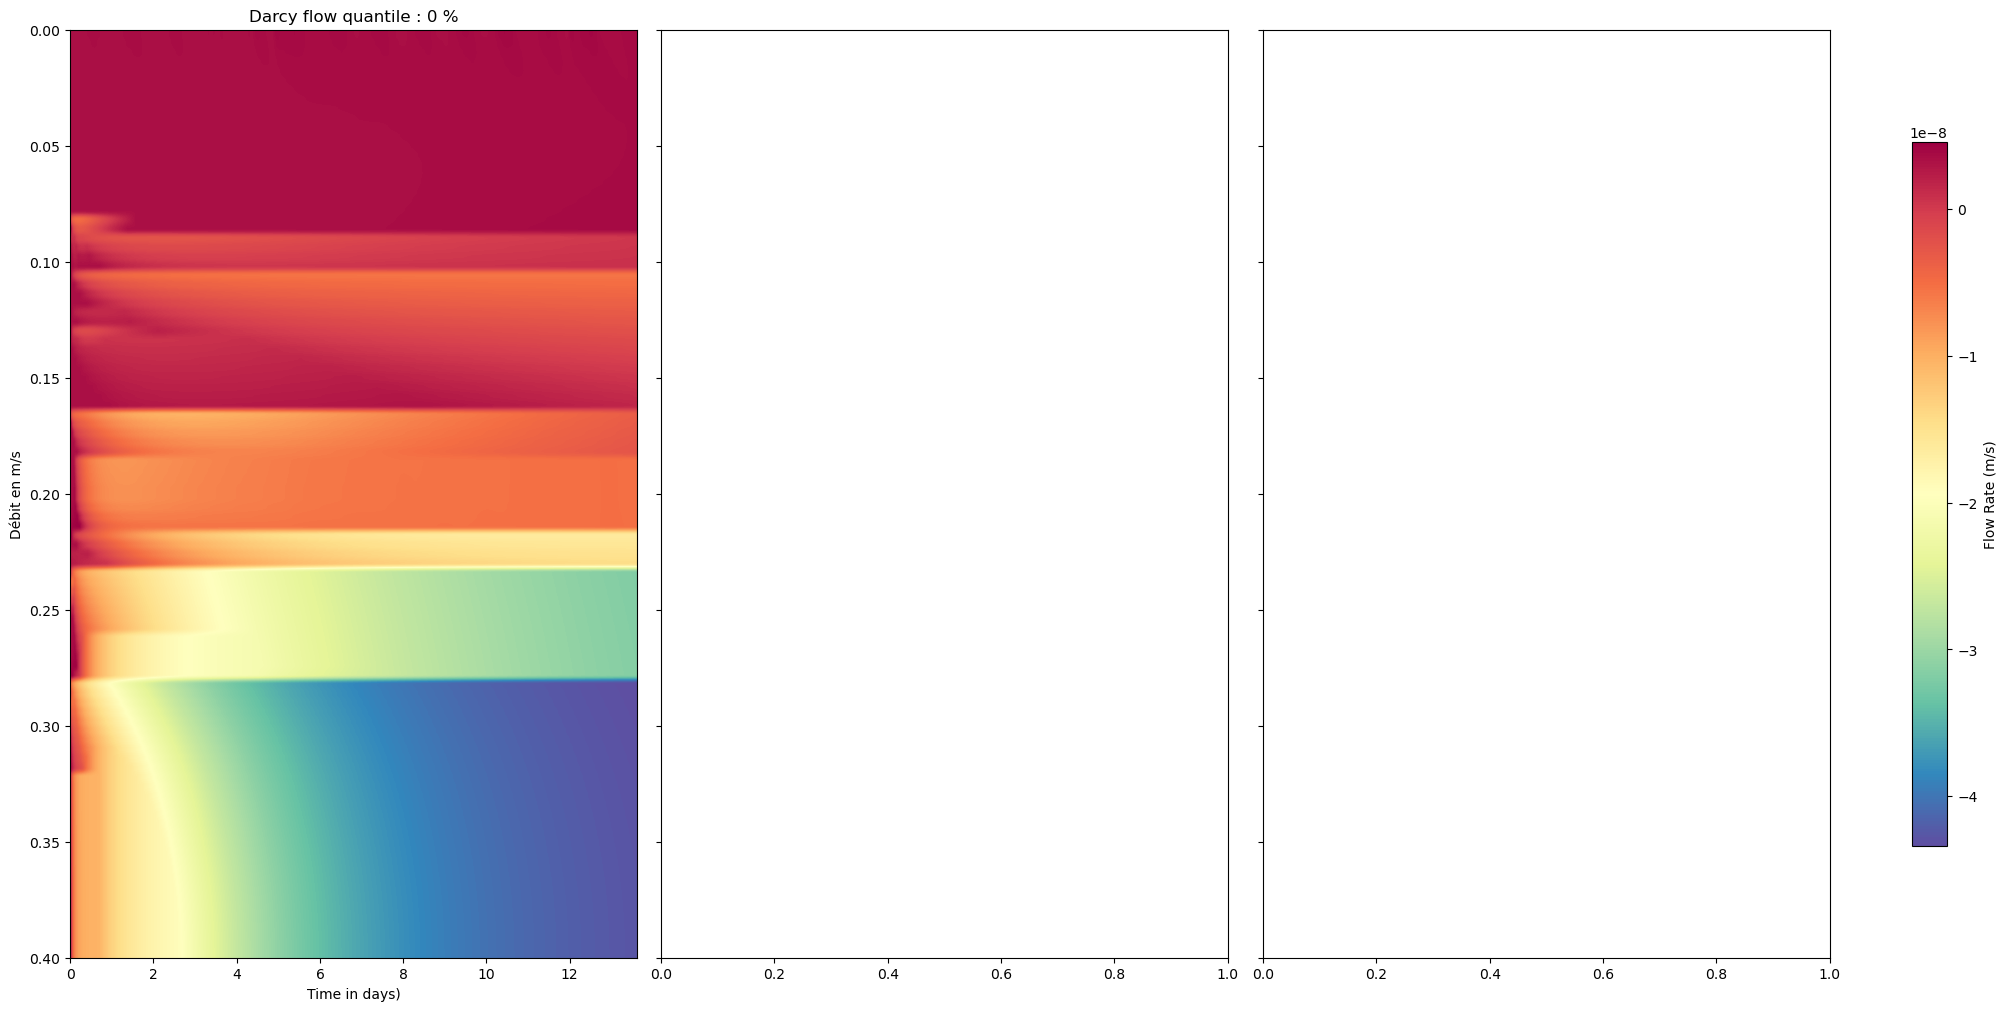

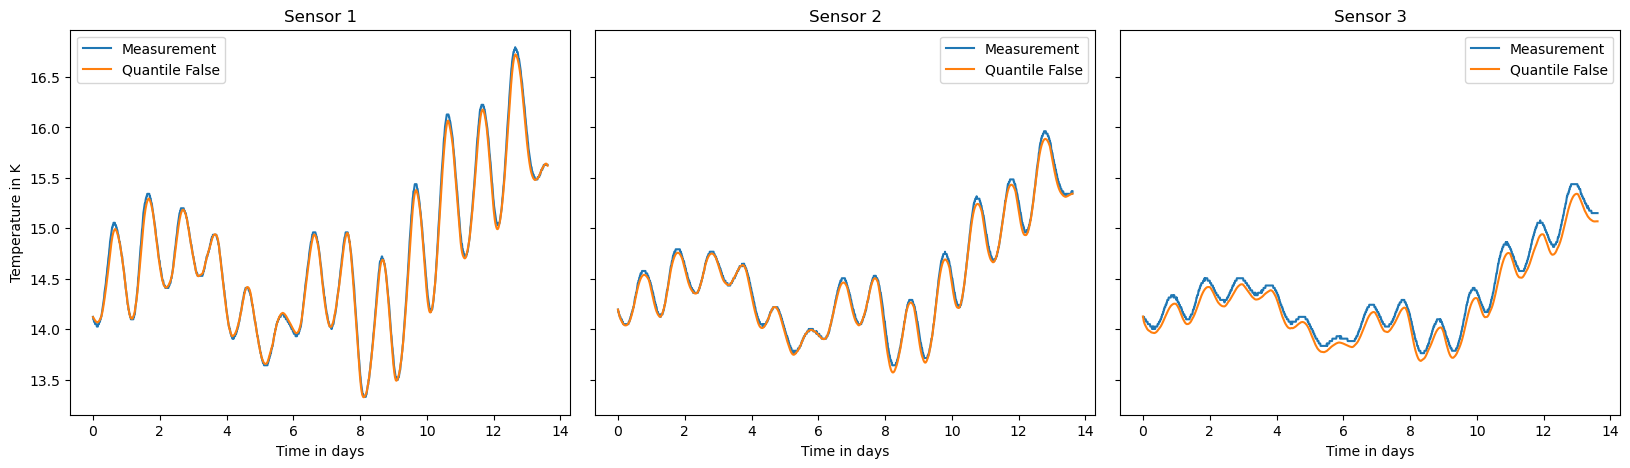

In [19]:
sigma_prior = Prior((0.1, np.inf), 0.1, lambda x : 1/x)

col.compute_mcmc(
    nb_iter = 50,
    all_priors = all_priors,
    sigma2_temp_prior = sigma_prior,
    verbose=False
)

bestLayers = col.get_best_layers()
col.compute_solve_transi(bestLayers,verbose=False)
col.plot_all_param_pdf()
col.plot_all_results()
col.plot_darcy_flow_quantile()
col.plot_quantile_temperatures_sensors()